## CV Assignment 2 - Task 1

Name: Muhammad Fahad Waqar<br>
Student No: st125981

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import time
from copy import deepcopy

In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 20
LR_ADAM = 0.001
LR_SGD = 0.01
MOMENTUM_SGD = 0.9

Using device: cuda


In [3]:
# Data Loading
CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

# Normalization stats for CIFAR-10
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

# Training transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# Testing transformations
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# Loading datasets
try:
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Loaded CIFAR-10 dataset.")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

except Exception as e:
    print(f"Error loading CIFAR-10 dataset. Make sure you have an internet connection. Error: {e}")
    train_loader = None
    test_loader = None

Files already downloaded and verified
Files already downloaded and verified
Loaded CIFAR-10 dataset.
Training samples: 50000
Test samples: 10000


In [4]:
# Model Definitions
# Model 1: Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model 2: ResNet-18
def get_resnet_model(num_classes=10):
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

In [5]:
# Training and Evaluation Functions
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_labels, all_predictions

In [6]:
# Learning Rate Scheduler Configurations
scheduler_configs = [
    {
        'name': 'None',
        'builder': lambda optimizer: None  # No scheduler
    },
    {
        'name': 'StepLR',
        'builder': lambda optimizer: optim.lr_scheduler.StepLR(
            optimizer, step_size=7, gamma=0.1
        )
    },
    {
        'name': 'ReduceLROnPlateau',
        'builder': lambda optimizer: optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5, verbose=True
        )
    }
]

# Updated Training Function with Scheduler Support
def train_one_epoch_with_scheduler(model, train_loader, optimizer, criterion, device):
    """Training function (same as before, no changes needed)"""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total_samples
    epoch_acc = 100.0 * correct_predictions / total_samples
    return epoch_loss, epoch_acc


In [7]:
# Visualization Functions
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title(f'Accuracy\n{title}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title(f'Loss\n{title}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(f'Training History: {title}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_confusion_matrix(all_labels, all_preds, class_names, title):
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 8))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def plot_misclassified(model, test_loader, class_names, device, title, num_images=10):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find mismatches
            mismatches = (predicted != labels)
            for i in range(images.size(0)):
                if mismatches[i] and len(misclassified_images) < num_images:
                    img = images[i].cpu()
                    img = img * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
                    img = transforms.ToPILImage()(img)
                    
                    misclassified_images.append(img)
                    misclassified_labels.append(class_names[labels[i]])
                    misclassified_preds.append(class_names[predicted[i]])
    
    # Plot the images
    if not misclassified_images:
        print(f"[{title}] No misclassified images found (or failed to find {num_images}).")
        return
        
    fig, axes = plt.subplots(1, len(misclassified_images), figsize=(20, 4))
    if len(misclassified_images) == 1:
        axes = [axes]
        
    for i, ax in enumerate(axes):
        ax.imshow(misclassified_images[i])
        ax.set_title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")
        ax.axis('off')
    
    plt.suptitle(f'Example Misclassified Images: {title}')
    plt.tight_layout()
    plt.show()


def plot_activation_maps(model, layers_to_plot, test_loader, device, title, num_images=5):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images.to(device)
    
    activations = {}
    handles = []

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu()
        return hook

    for layer_name, layer in layers_to_plot.items():
        handles.append(layer.register_forward_hook(get_activation(layer_name)))

    with torch.no_grad():
        _ = model(images)

    for handle in handles:
        handle.remove()
        
    # Plot original images
    fig, axes = plt.subplots(num_images, 1, figsize=(3, 2 * num_images))
    if num_images == 1: axes = [axes]
    plt.suptitle(f'Original Images\n{title}', x=0.5, y=1.02, fontsize=14)
    for i in range(num_images):
        img = images[i].cpu()
        img = img * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
        img = img.permute(1, 2, 0)
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()
    
    # Plot activation maps for each layer
    for layer_name, activation in activations.items():
        num_features = activation.size(1)
        
        # Plotting the first 8 features
        features_to_plot = min(num_features, 8) 
        
        fig, axes = plt.subplots(num_images, features_to_plot, figsize=(features_to_plot * 2, num_images * 2))
        
        if num_images == 1:
            axes = axes.reshape(1, -1)
        if features_to_plot == 1:
            axes = axes.reshape(-1, 1)

        for i in range(num_images):
            for j in range(features_to_plot):
                ax = axes[i, j]
                ax.imshow(activation[i, j], cmap='viridis')
                ax.axis('off')
                if i == 0:
                    ax.set_title(f'Filter {j+1}')
        
        plt.suptitle(f'Activation Maps: {layer_name}\n{title}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [8]:
# Experiment
model_configs = [
    {'name': 'SimpleCNN', 'builder': SimpleCNN},
    {'name': 'ResNet-18', 'builder': get_resnet_model}
]

# Define the 4 optimizer configurations
optimizer_configs = [
    {
        'name': 'Adam',
        'builder': lambda params: optim.Adam(params, lr=LR_ADAM)
    },
    {
        'name': 'SGD_Vanilla',
        'builder': lambda params: optim.SGD(params, lr=LR_SGD)
    },
    {
        'name': 'SGD_Momentum',
        'builder': lambda params: optim.SGD(params, lr=LR_SGD, momentum=MOMENTUM_SGD)
    },
    {
        'name': 'SGD_Nesterov',
        'builder': lambda params: optim.SGD(params, lr=LR_SGD, momentum=MOMENTUM_SGD, nesterov=True)
    }
]

# Loss function
criterion = nn.CrossEntropyLoss()

# Dictionary to store all results
experiment_results = {}

# Check if data loaders are available
if train_loader is None or test_loader is None:
    print("FATAL: Data loaders were not initialized. Stopping experiment.")
else:
    # --- Main Training Loop ---
    
    for model_config in model_configs:
        for optimizer_config in optimizer_configs:
            
            experiment_name = f"{model_config['name']}_{optimizer_config['name']}"
            print(f"STARTING EXPERIMENT: {experiment_name}")
            
            # 1. Initialize model and optimizer
            model = model_config['builder']().to(DEVICE)
            optimizer = optimizer_config['builder'](model.parameters())
            
            # Store history for this run
            history = {
                'train_loss': [], 'train_acc': [],
                'val_loss': [], 'val_acc': []
            }
            
            start_time = time.time()
            
            # 2. Run training epochs
            for epoch in range(NUM_EPOCHS):
                
                # Train
                train_loss, train_acc = train_one_epoch(
                    model, train_loader, optimizer, criterion, DEVICE)
                
                # Validate
                val_loss, val_acc, _, _ = evaluate_model(
                    model, test_loader, criterion, DEVICE)
                
                # Log results
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                
                print(f"  Epoch [{epoch+1:02d}/{NUM_EPOCHS}] | "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            end_time = time.time()
            print(f"FINISHED EXPERIMENT: {experiment_name}")
            print(f"   Total Time: {end_time - start_time:.2f} seconds")
            
            # 3. Store results (model state and history)
            experiment_results[experiment_name] = {
                'model_state': deepcopy(model.state_dict()), # Save a copy of the weights
                'model_config': model_config,
                'history': history,
                'time': end_time - start_time
            }
            
            # Clean up memory
            del model
            del optimizer
            if DEVICE == 'cuda':
                torch.cuda.empty_cache()

    print("All 8 experiments completed!")

STARTING EXPERIMENT: SimpleCNN_Adam
  Epoch [01/20] | Train Loss: 1.6083, Train Acc: 41.47% | Val Loss: 1.2970, Val Acc: 54.30%
  Epoch [02/20] | Train Loss: 1.3215, Train Acc: 52.60% | Val Loss: 1.1343, Val Acc: 59.13%
  Epoch [03/20] | Train Loss: 1.1899, Train Acc: 57.52% | Val Loss: 1.0625, Val Acc: 62.96%
  Epoch [04/20] | Train Loss: 1.0991, Train Acc: 60.83% | Val Loss: 0.9978, Val Acc: 64.49%
  Epoch [05/20] | Train Loss: 1.0382, Train Acc: 63.19% | Val Loss: 0.9326, Val Acc: 67.43%
  Epoch [06/20] | Train Loss: 0.9912, Train Acc: 64.81% | Val Loss: 0.9000, Val Acc: 68.74%
  Epoch [07/20] | Train Loss: 0.9488, Train Acc: 66.74% | Val Loss: 0.9040, Val Acc: 68.45%
  Epoch [08/20] | Train Loss: 0.9131, Train Acc: 67.75% | Val Loss: 0.8395, Val Acc: 70.45%
  Epoch [09/20] | Train Loss: 0.8872, Train Acc: 68.68% | Val Loss: 0.8355, Val Acc: 70.45%
  Epoch [10/20] | Train Loss: 0.8615, Train Acc: 69.85% | Val Loss: 0.8295, Val Acc: 71.06%
  Epoch [11/20] | Train Loss: 0.8362, Train 

STARTING EXPERIMENTS WITH LEARNING RATE SCHEDULERS

STARTING EXPERIMENT: SimpleCNN_Adam_None
------------------------------------------------------------
  Epoch [01/20] | Train Loss: 1.6152, Train Acc: 41.25% | Val Loss: 1.3441, Val Acc: 52.00% | LR: 0.001000
  Epoch [02/20] | Train Loss: 1.3233, Train Acc: 52.00% | Val Loss: 1.1465, Val Acc: 59.03% | LR: 0.001000
  Epoch [03/20] | Train Loss: 1.1873, Train Acc: 57.67% | Val Loss: 1.0365, Val Acc: 62.94% | LR: 0.001000
  Epoch [04/20] | Train Loss: 1.0995, Train Acc: 61.08% | Val Loss: 0.9747, Val Acc: 65.81% | LR: 0.001000
  Epoch [05/20] | Train Loss: 1.0279, Train Acc: 63.60% | Val Loss: 0.9220, Val Acc: 67.37% | LR: 0.001000
  Epoch [06/20] | Train Loss: 0.9813, Train Acc: 65.21% | Val Loss: 0.8892, Val Acc: 69.00% | LR: 0.001000
  Epoch [07/20] | Train Loss: 0.9444, Train Acc: 66.53% | Val Loss: 0.8582, Val Acc: 69.93% | LR: 0.001000
  Epoch [08/20] | Train Loss: 0.9105, Train Acc: 67.72% | Val Loss: 0.8416, Val Acc: 70.85% | LR:

c:\Users\mfaha\miniconda3\envs\cuda_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch [01/20] | Train Loss: 1.6145, Train Acc: 41.33% | Val Loss: 1.2910, Val Acc: 53.36% | LR: 0.001000
  Epoch [02/20] | Train Loss: 1.3124, Train Acc: 53.08% | Val Loss: 1.1207, Val Acc: 59.88% | LR: 0.001000
  Epoch [03/20] | Train Loss: 1.1845, Train Acc: 57.96% | Val Loss: 1.0682, Val Acc: 61.95% | LR: 0.001000
  Epoch [04/20] | Train Loss: 1.0998, Train Acc: 60.93% | Val Loss: 0.9839, Val Acc: 65.21% | LR: 0.001000
  Epoch [05/20] | Train Loss: 1.0357, Train Acc: 63.53% | Val Loss: 0.9474, Val Acc: 66.95% | LR: 0.001000
  Epoch [06/20] | Train Loss: 0.9875, Train Acc: 65.12% | Val Loss: 0.9167, Val Acc: 67.57% | LR: 0.001000
  Epoch [07/20] | Train Loss: 0.9578, Train Acc: 66.04% | Val Loss: 0.8764, Val Acc: 69.16% | LR: 0.001000
  Epoch [08/20] | Train Loss: 0.9216, Train Acc: 67.49% | Val Loss: 0.8875, Val Acc: 68.92% | LR: 0.001000
  Epoch [09/20] | Train Loss: 0.8965, Train Acc: 68.62% | Val Loss: 0.8398, Val Acc: 70.72% | LR: 0.001000
  Epoch [10/20] | Train Loss: 0.8699,

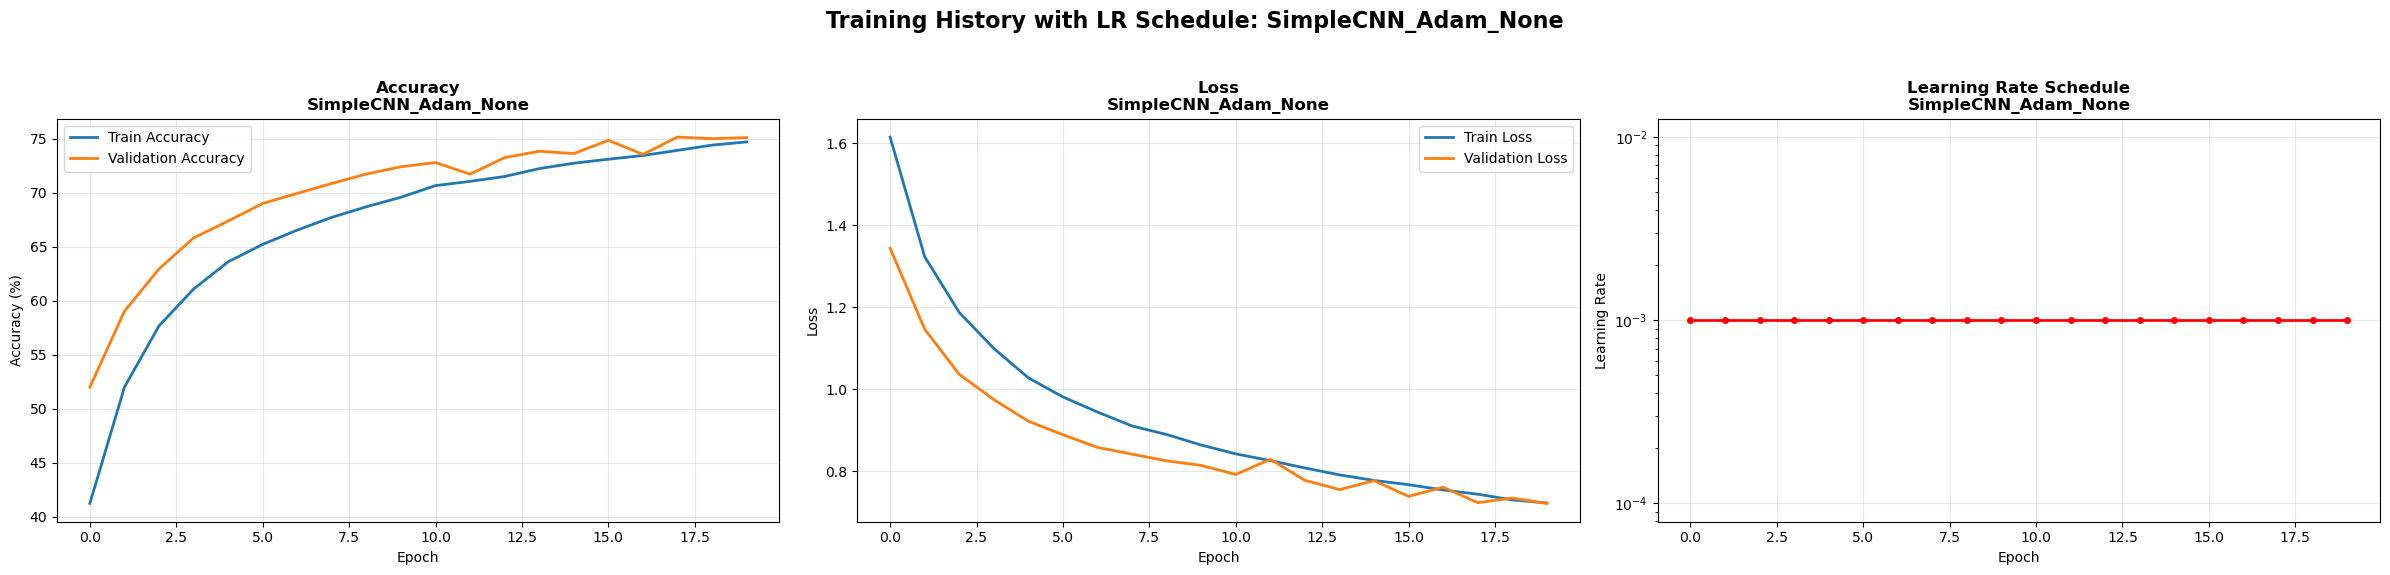


  Summary Statistics:
- Best Validation Accuracy: 75.14% (Epoch 18)
- Final Validation Accuracy: 75.09%
- Training Time: 604.44 seconds
- Scheduler Used: None

Analyzing: SimpleCNN_Adam_StepLR
------------------------------------------------------------
[Plotting] Training History with LR for SimpleCNN_Adam_StepLR...


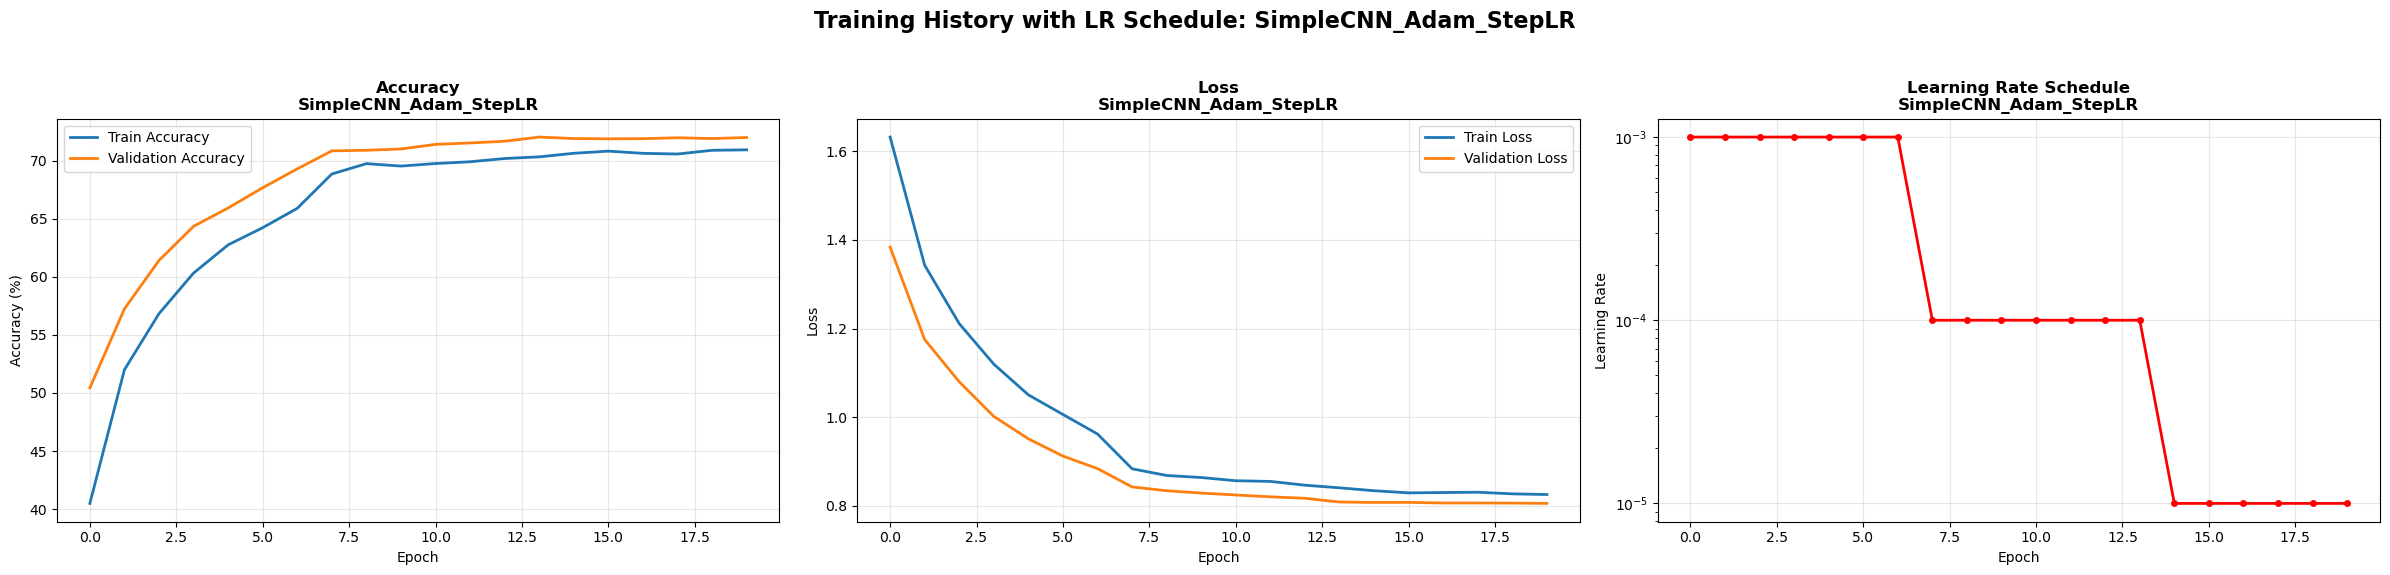


  Summary Statistics:
- Best Validation Accuracy: 72.05% (Epoch 14)
- Final Validation Accuracy: 72.01%
- Training Time: 587.59 seconds
- Scheduler Used: StepLR

Analyzing: SimpleCNN_Adam_ReduceLROnPlateau
------------------------------------------------------------
[Plotting] Training History with LR for SimpleCNN_Adam_ReduceLROnPlateau...


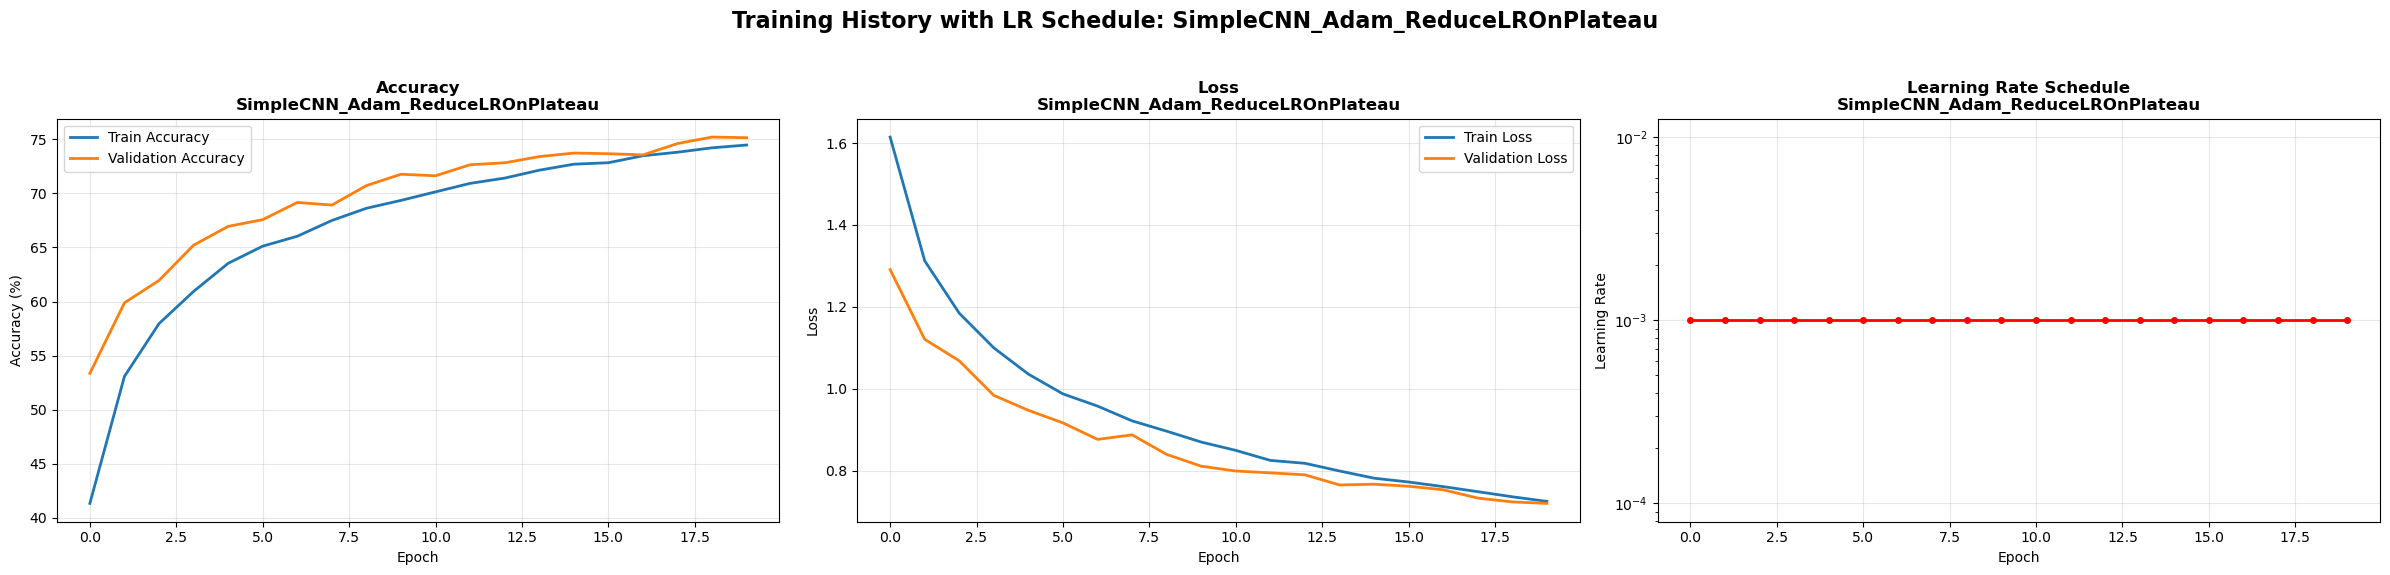


  Summary Statistics:
- Best Validation Accuracy: 75.21% (Epoch 19)
- Final Validation Accuracy: 75.15%
- Training Time: 598.43 seconds
- Scheduler Used: ReduceLROnPlateau

Analyzing: ResNet-18_Adam_None
------------------------------------------------------------
[Plotting] Training History with LR for ResNet-18_Adam_None...


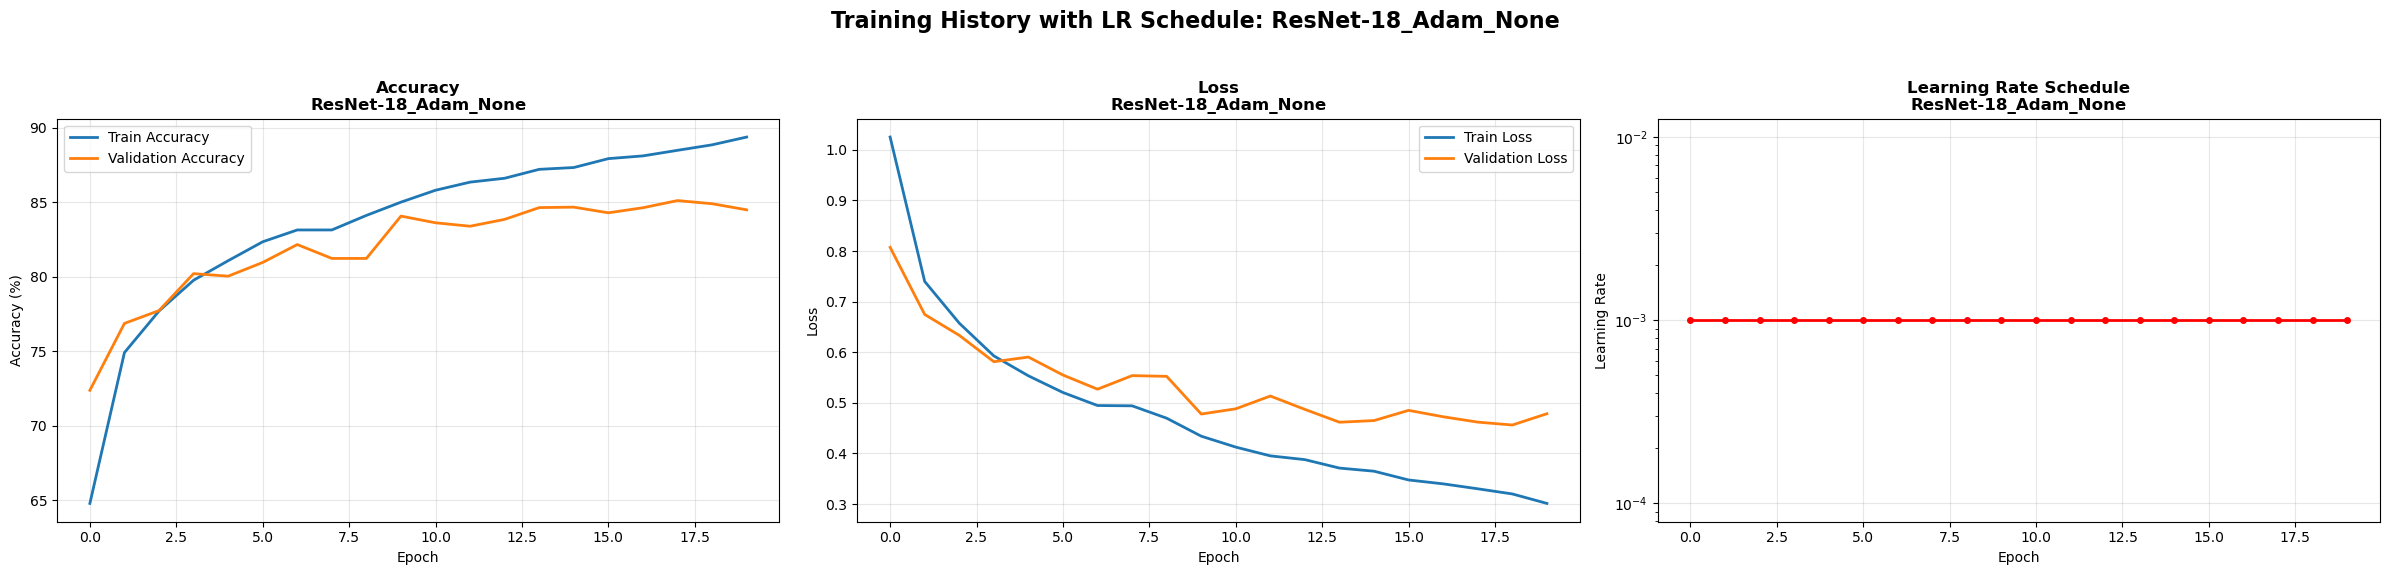


  Summary Statistics:
- Best Validation Accuracy: 85.10% (Epoch 18)
- Final Validation Accuracy: 84.48%
- Training Time: 642.29 seconds
- Scheduler Used: None

Analyzing: ResNet-18_Adam_StepLR
------------------------------------------------------------
[Plotting] Training History with LR for ResNet-18_Adam_StepLR...


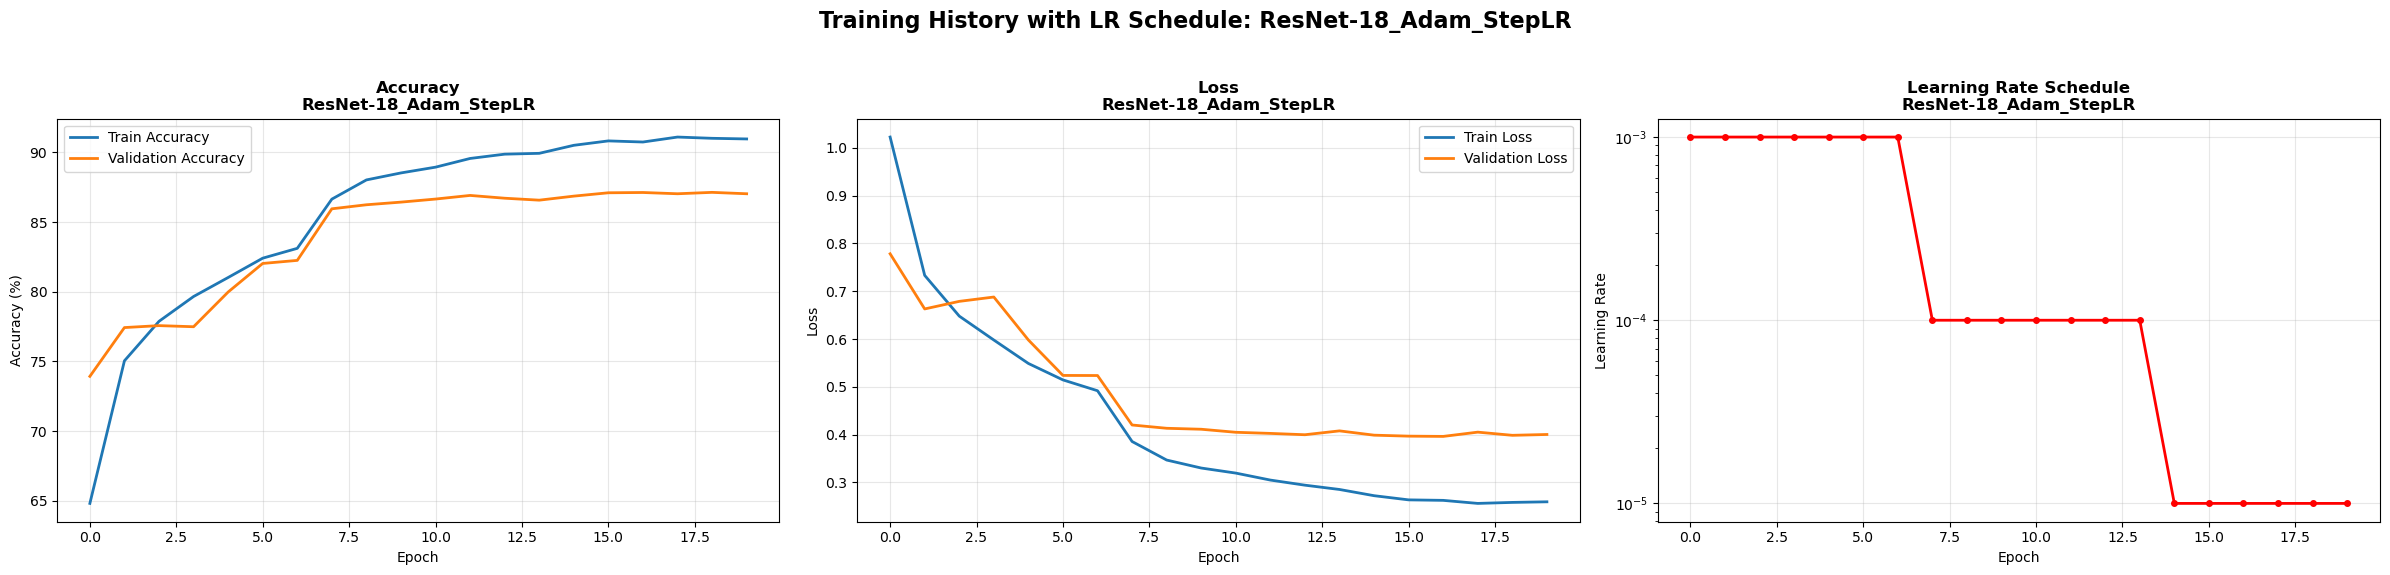


  Summary Statistics:
- Best Validation Accuracy: 87.13% (Epoch 19)
- Final Validation Accuracy: 87.03%
- Training Time: 768.41 seconds
- Scheduler Used: StepLR

Analyzing: ResNet-18_Adam_ReduceLROnPlateau
------------------------------------------------------------
[Plotting] Training History with LR for ResNet-18_Adam_ReduceLROnPlateau...


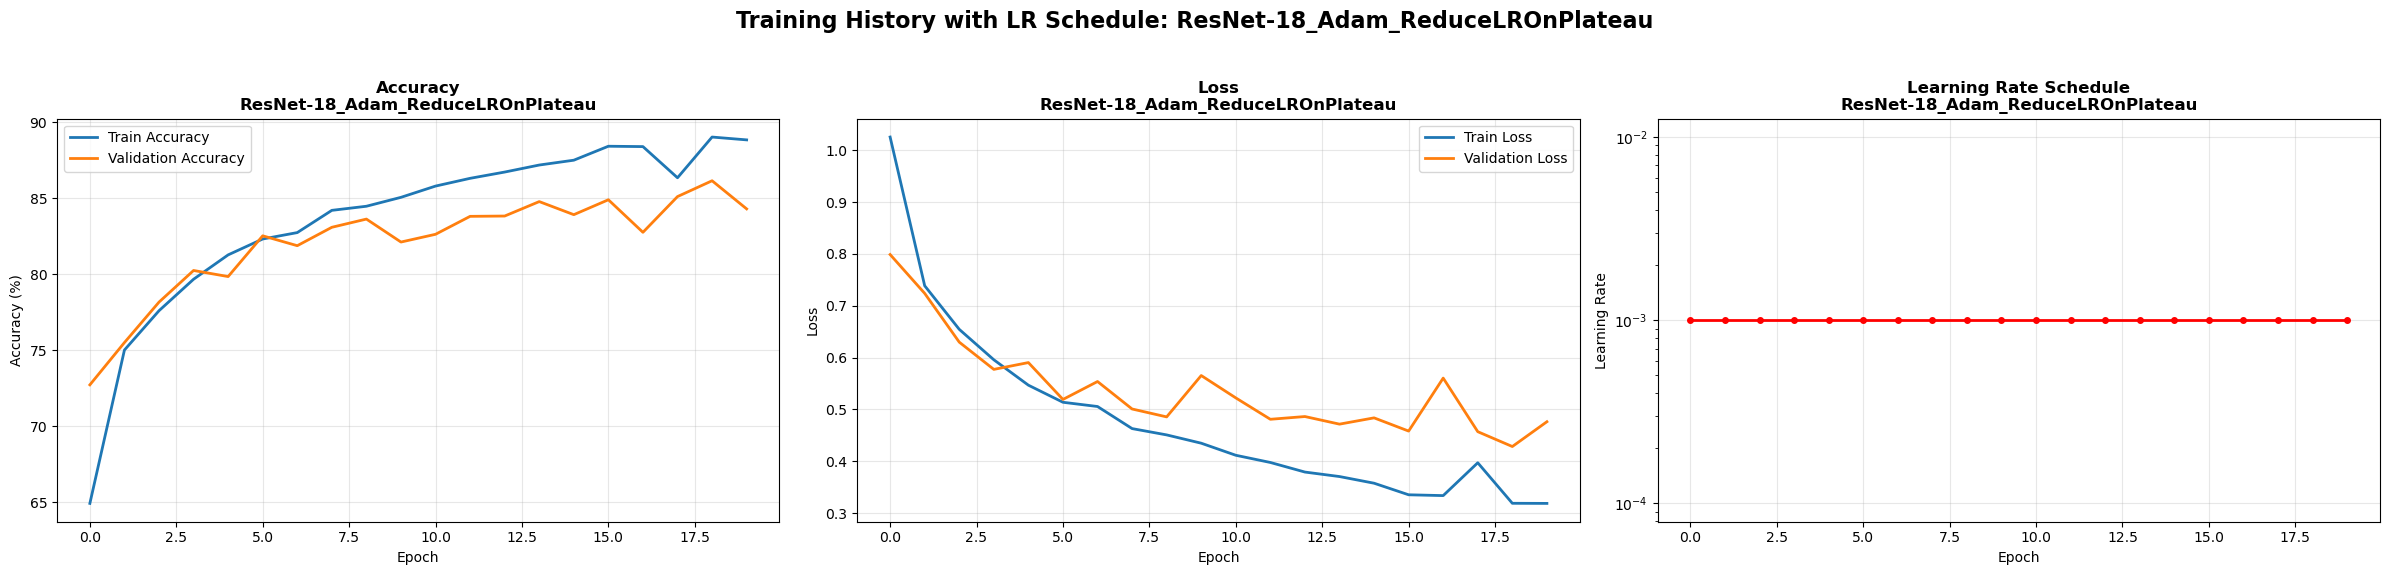


  Summary Statistics:
- Best Validation Accuracy: 86.14% (Epoch 19)
- Final Validation Accuracy: 84.29%
- Training Time: 733.79 seconds
- Scheduler Used: ReduceLROnPlateau
Schedular Comparison Table
                      Experiment         Scheduler Best Val Acc (%) Final Val Acc (%) Time (s) Final LR
             SimpleCNN_Adam_None              None            75.14             75.09   604.44 0.001000
           SimpleCNN_Adam_StepLR            StepLR            72.05             72.01   587.59 0.000010
SimpleCNN_Adam_ReduceLROnPlateau ReduceLROnPlateau            75.21             75.15   598.43 0.001000
             ResNet-18_Adam_None              None            85.10             84.48   642.29 0.001000
           ResNet-18_Adam_StepLR            StepLR            87.13             87.03   768.41 0.000010
ResNet-18_Adam_ReduceLROnPlateau ReduceLROnPlateau            86.14             84.29   733.79 0.001000


In [10]:
# Dictionary to store all results
experiment_results_with_schedulers = {}

# Select specific configurations to test with schedulers
# To keep experiments manageable, we'll test schedulers with Adam optimizer only
model_configs_for_scheduler = [
    {'name': 'SimpleCNN', 'builder': SimpleCNN},
    {'name': 'ResNet-18', 'builder': get_resnet_model}
]

optimizer_config_for_scheduler = {
    'name': 'Adam',
    'builder': lambda params: optim.Adam(params, lr=LR_ADAM)
}

if train_loader is None or test_loader is None:
    print("FATAL: Data loaders were not initialized. Stopping experiment.")
else:
    print("STARTING EXPERIMENTS WITH LEARNING RATE SCHEDULERS")
    
    for model_config in model_configs_for_scheduler:
        for scheduler_config in scheduler_configs:
            experiment_name = f"{model_config['name']}_{optimizer_config_for_scheduler['name']}_{scheduler_config['name']}"
            print(f"\nSTARTING EXPERIMENT: {experiment_name}")
            print("-" * 60)
            
            # Initialize model, optimizer, and scheduler
            model = model_config['builder']().to(DEVICE)
            optimizer = optimizer_config_for_scheduler['builder'](model.parameters())
            scheduler = scheduler_config['builder'](optimizer)
            
            # Store history for this run
            history = {
                'train_loss': [], 'train_acc': [],
                'val_loss': [], 'val_acc': [],
                'learning_rates': []
            }
            
            start_time = time.time()
            
            # Run training epochs
            for epoch in range(NUM_EPOCHS):
                # Train
                train_loss, train_acc = train_one_epoch_with_scheduler(
                    model, train_loader, optimizer, criterion, DEVICE)
                
                # Validate
                val_loss, val_acc, _, _ = evaluate_model(
                    model, test_loader, criterion, DEVICE)
                
                # Log results
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                
                # Get current learning rate
                current_lr = optimizer.param_groups[0]['lr']
                history['learning_rates'].append(current_lr)
                
                # Step the scheduler
                if scheduler is not None:
                    if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(val_loss)
                    else:
                        scheduler.step()
                
                print(f"  Epoch [{epoch+1:02d}/{NUM_EPOCHS}] | "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
                      f"LR: {current_lr:.6f}")
            
            end_time = time.time()
            print(f"\nFINISHED EXPERIMENT: {experiment_name}")
            print(f"  Total Time: {end_time - start_time:.2f} seconds")
            print(f"  Best Val Acc: {max(history['val_acc']):.2f}%")
            
            # Store results
            experiment_results_with_schedulers[experiment_name] = {
                'model_state': deepcopy(model.state_dict()),
                'model_config': model_config,
                'history': history,
                'time': end_time - start_time,
                'scheduler_name': scheduler_config['name']
            }
            
            # Clean up memory
            del model
            del optimizer
            del scheduler
            if DEVICE == 'cuda':
                torch.cuda.empty_cache()
    
    print("\n" + "="*80)
    print("All Schedular Experiments Done.")
    print("="*80)

# Enhanced Visualization Function for Schedulers

def plot_history_with_lr(history, title):
    """Plot training history including learning rate"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    
    # Accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax1.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'Accuracy\n{title}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax2.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'Loss\n{title}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning Rate
    ax3.plot(history['learning_rates'], color='red', linewidth=2, marker='o', markersize=4)
    ax3.set_title(f'Learning Rate Schedule\n{title}', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')  # Log scale to better visualize LR changes
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'Training History with LR Schedule: {title}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Analyze and Visualize Scheduler Results
if experiment_results_with_schedulers:
    print("\n" + "="*80)
    print("Analyzing Schedular Experiments")
    print("="*80 + "\n")
    
    for experiment_name, results in experiment_results_with_schedulers.items():
        print(f"\nAnalyzing: {experiment_name}")
        print("-" * 60)
        
        # Plot enhanced training history with LR
        print(f"[Plotting] Training History with LR for {experiment_name}...")
        plot_history_with_lr(results['history'], title=experiment_name)
        
        # Print summary statistics
        best_val_acc = max(results['history']['val_acc'])
        best_epoch = results['history']['val_acc'].index(best_val_acc) + 1
        final_val_acc = results['history']['val_acc'][-1]
        
        print(f"\n  Summary Statistics:")
        print(f"- Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
        print(f"- Final Validation Accuracy: {final_val_acc:.2f}%")
        print(f"- Training Time: {results['time']:.2f} seconds")
        print(f"- Scheduler Used: {results['scheduler_name']}")

# Comparison Table for Schedulers
def create_scheduler_comparison_table(results_dict):   
    comparison_data = []
    for exp_name, results in results_dict.items():
        comparison_data.append({
            'Experiment': exp_name,
            'Scheduler': results['scheduler_name'],
            'Best Val Acc (%)': f"{max(results['history']['val_acc']):.2f}",
            'Final Val Acc (%)': f"{results['history']['val_acc'][-1]:.2f}",
            'Time (s)': f"{results['time']:.2f}",
            'Final LR': f"{results['history']['learning_rates'][-1]:.6f}"
        })
    
    df = pd.DataFrame(comparison_data)
    print("Schedular Comparison Table")
    print(df.to_string(index=False))
    
    return df

if experiment_results_with_schedulers:
    scheduler_comparison_df = create_scheduler_comparison_table(experiment_results_with_schedulers)

Analyzing: SimpleCNN_Adam
[Plotting] Training History for SimpleCNN_Adam...


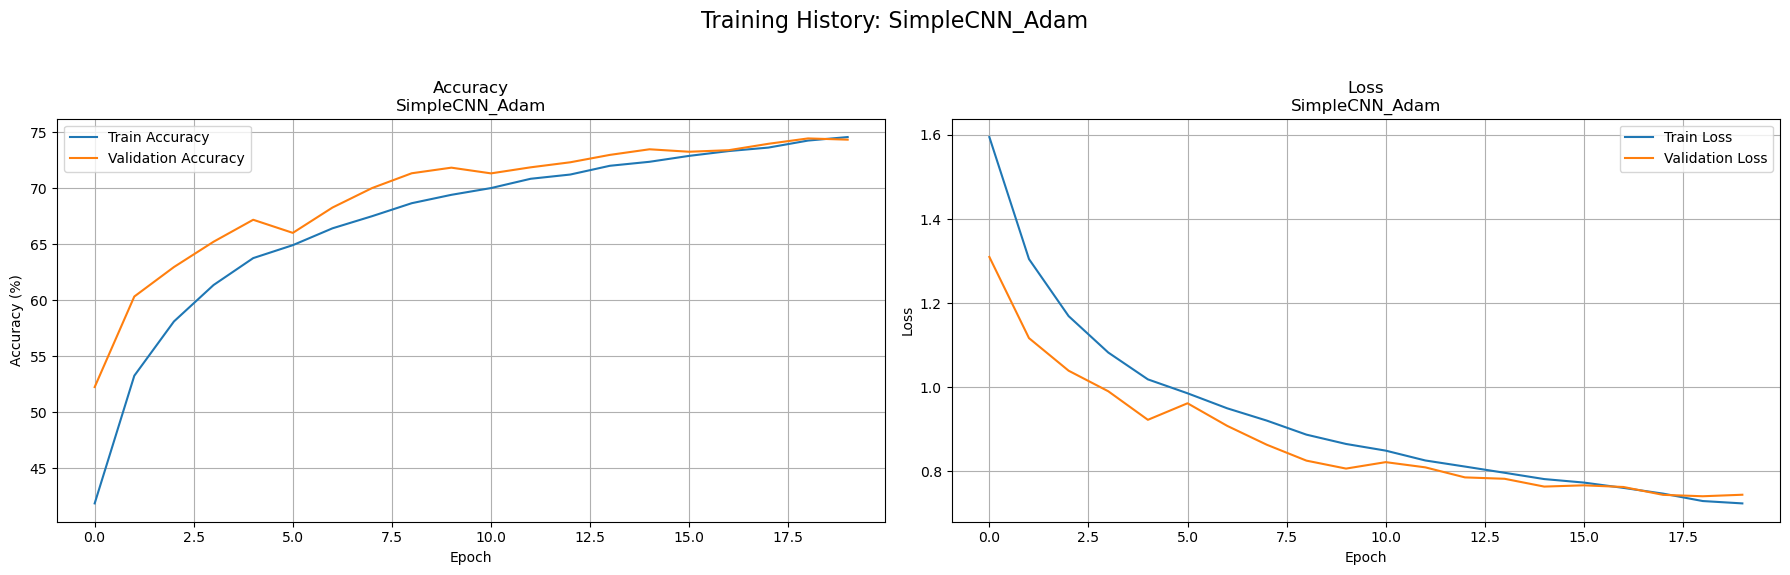

[Evaluating] Final model for SimpleCNN_Adam...
[Plotting] Confusion Matrix for SimpleCNN_Adam...


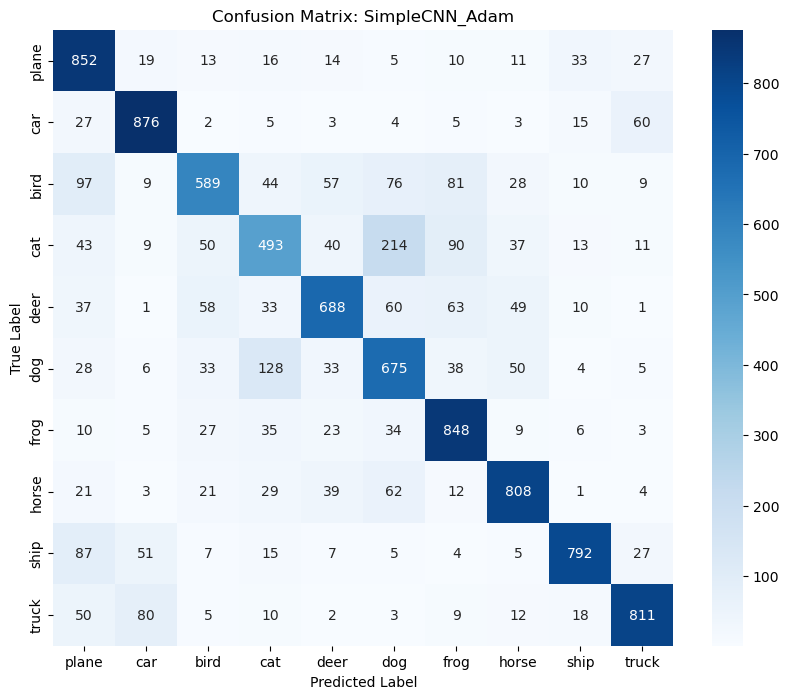

[Plotting] Misclassified Images for SimpleCNN_Adam...


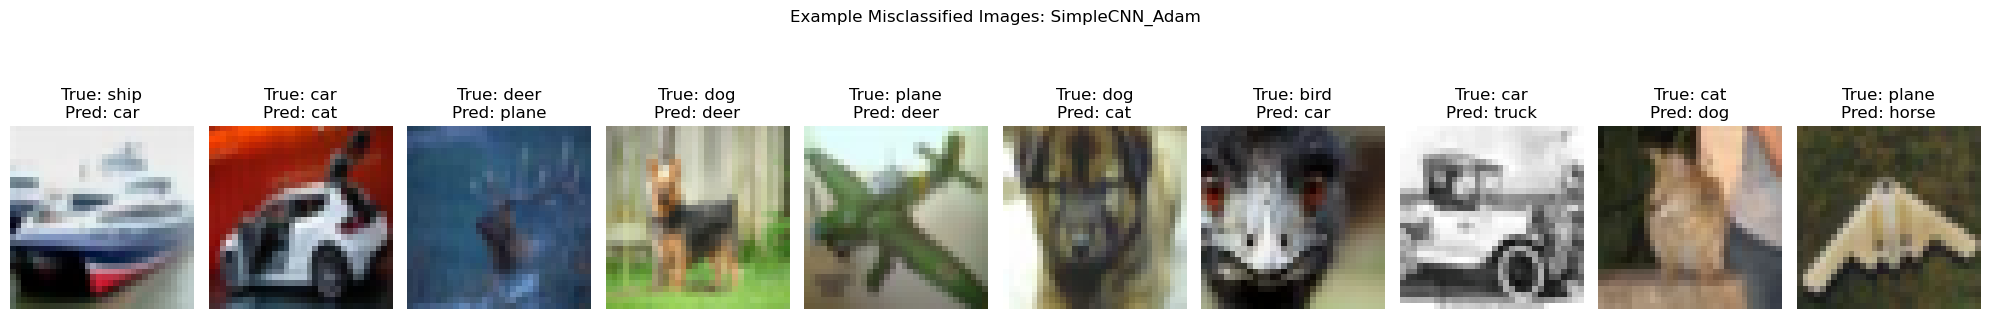

[Plotting] Activation Maps for SimpleCNN_Adam...


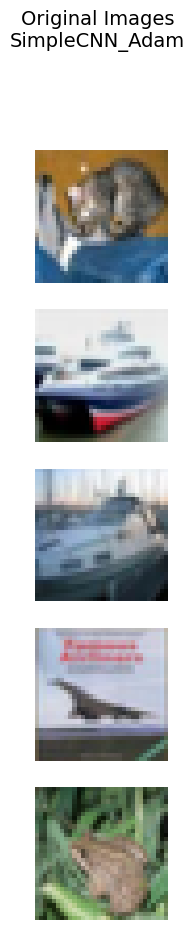

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001D085FE1FC0>
Traceback (most recent call last):
  File "c:\Users\mfaha\miniconda3\envs\cuda_env\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\mfaha\miniconda3\envs\cuda_env\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


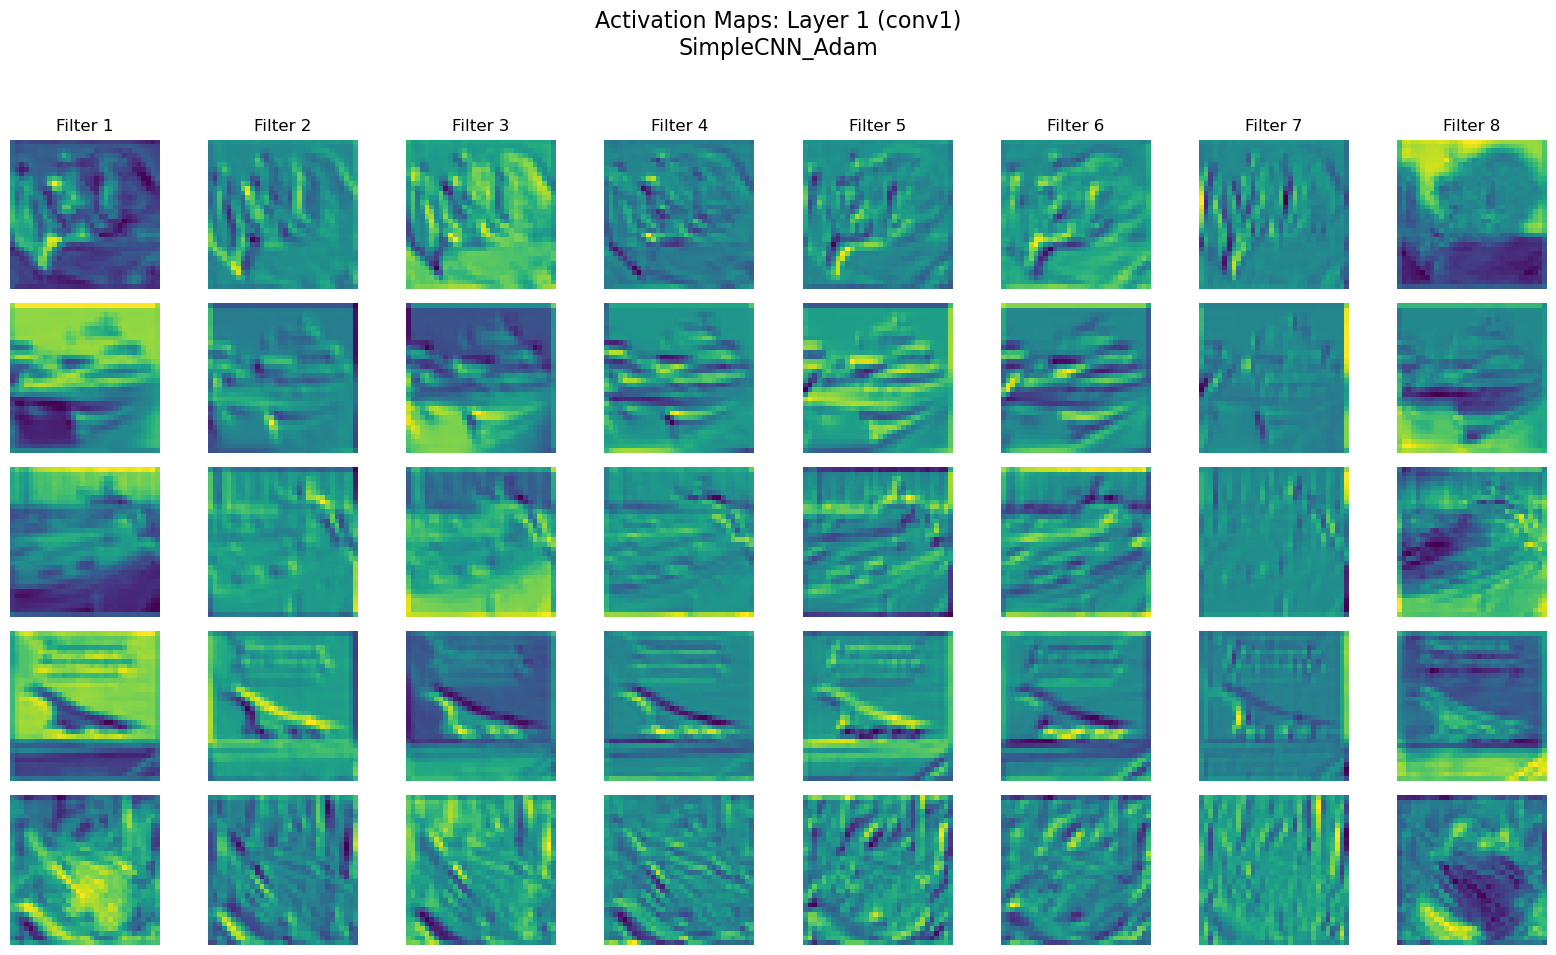

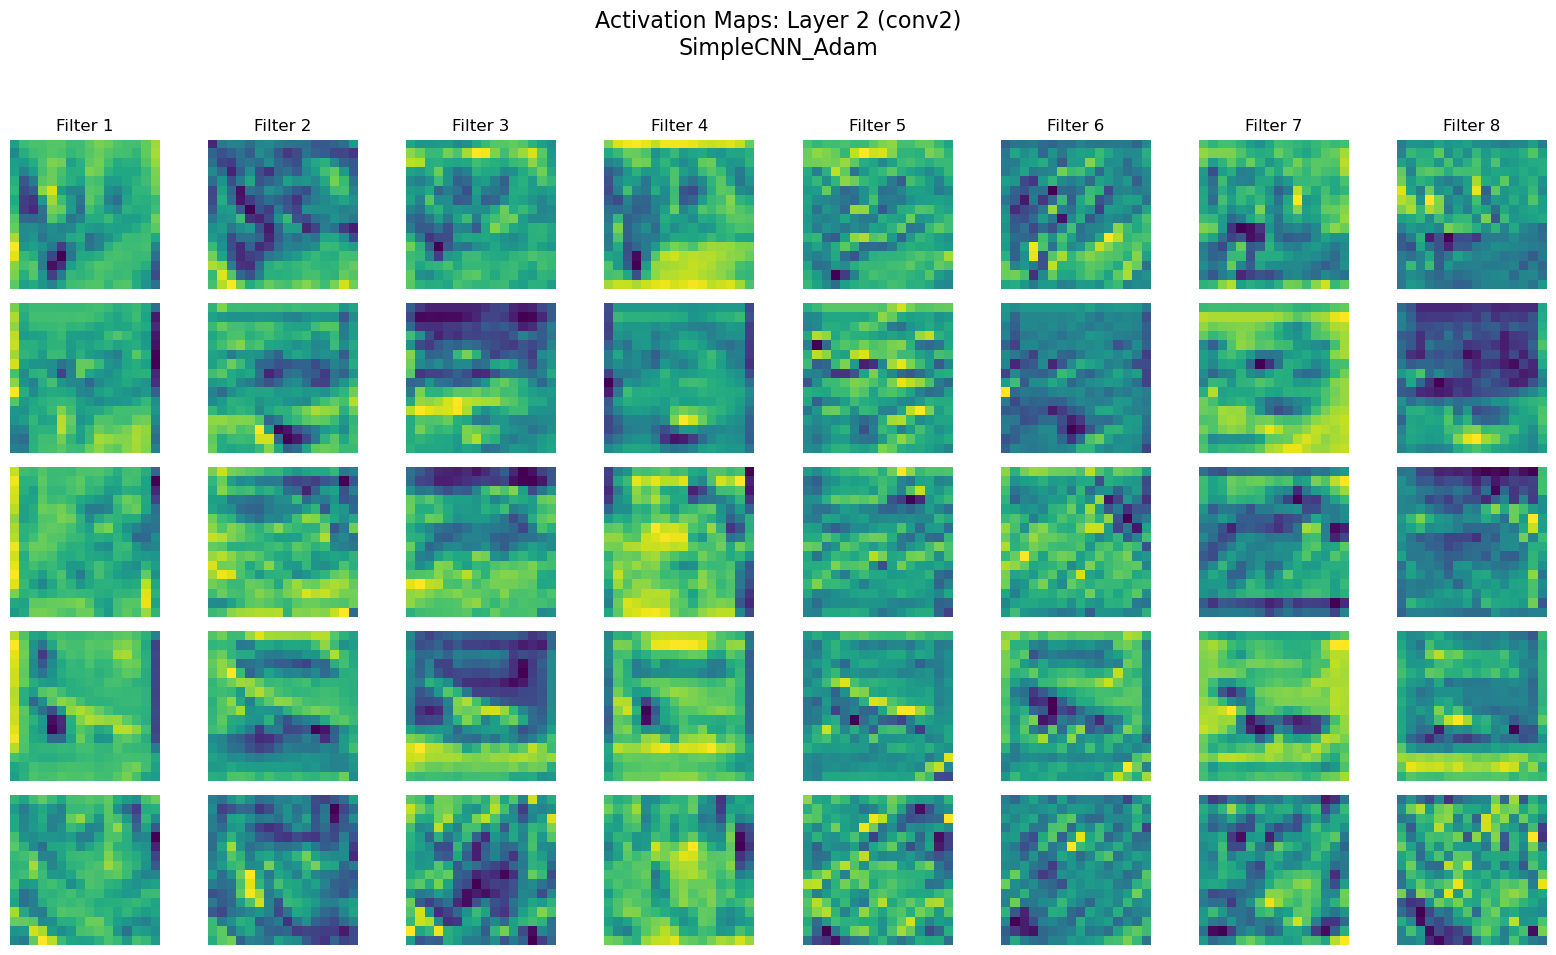

Analyzing: SimpleCNN_SGD_Vanilla
[Plotting] Training History for SimpleCNN_SGD_Vanilla...


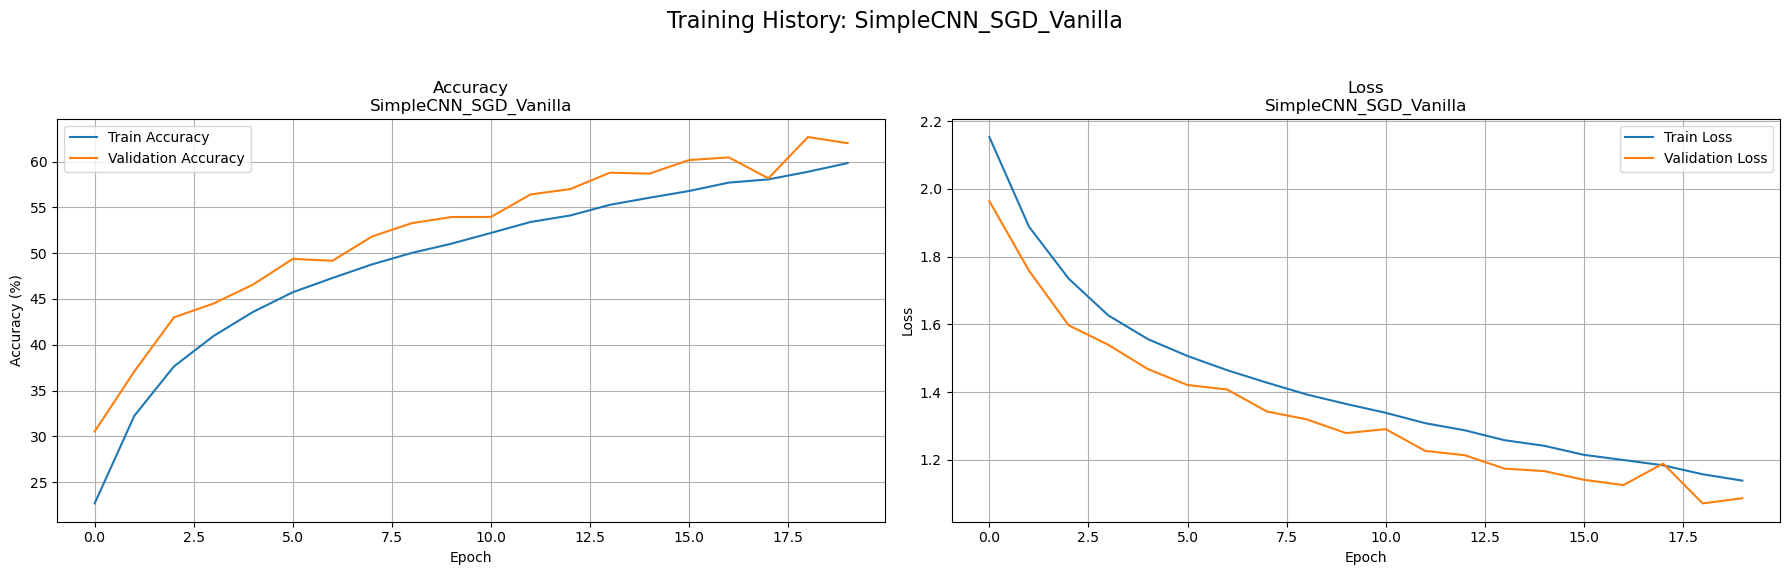

[Evaluating] Final model for SimpleCNN_SGD_Vanilla...
[Plotting] Confusion Matrix for SimpleCNN_SGD_Vanilla...


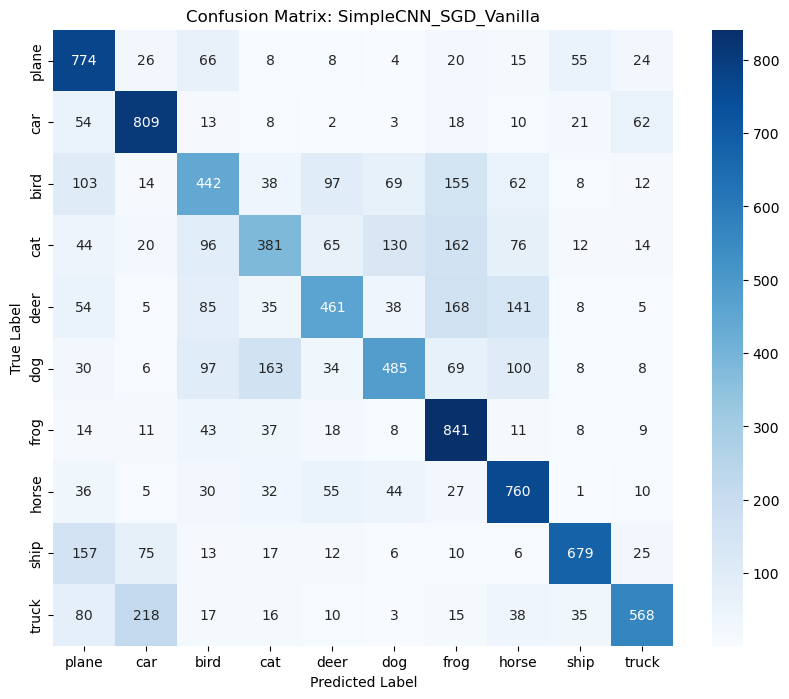

[Plotting] Misclassified Images for SimpleCNN_SGD_Vanilla...


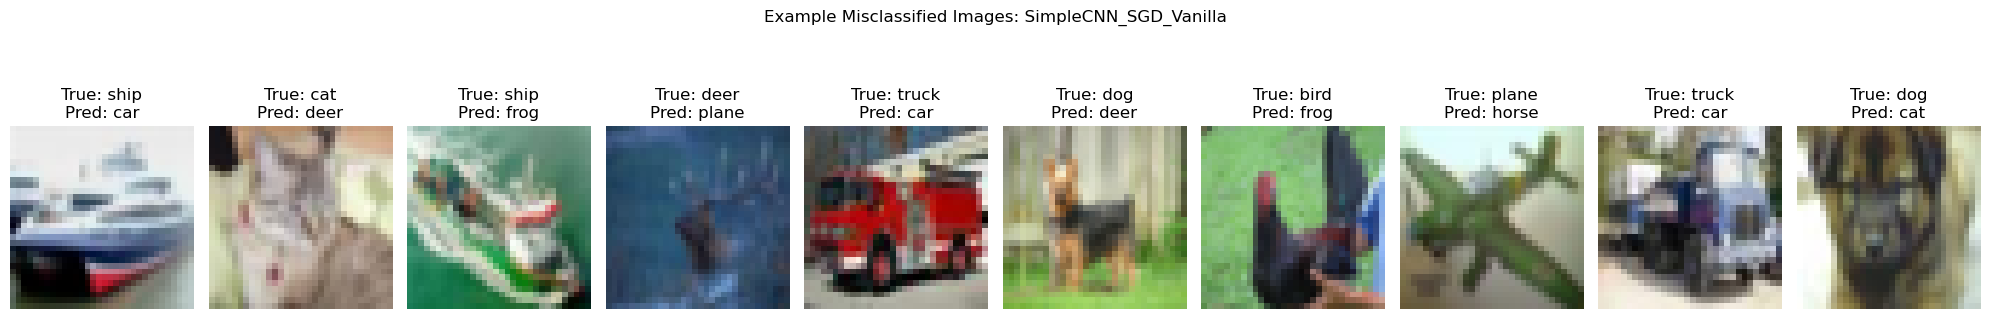

[Plotting] Activation Maps for SimpleCNN_SGD_Vanilla...


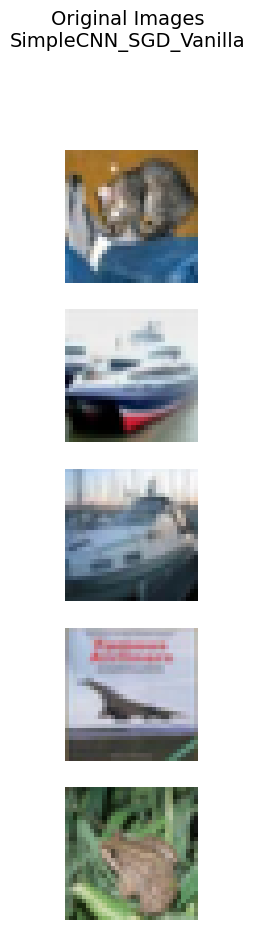

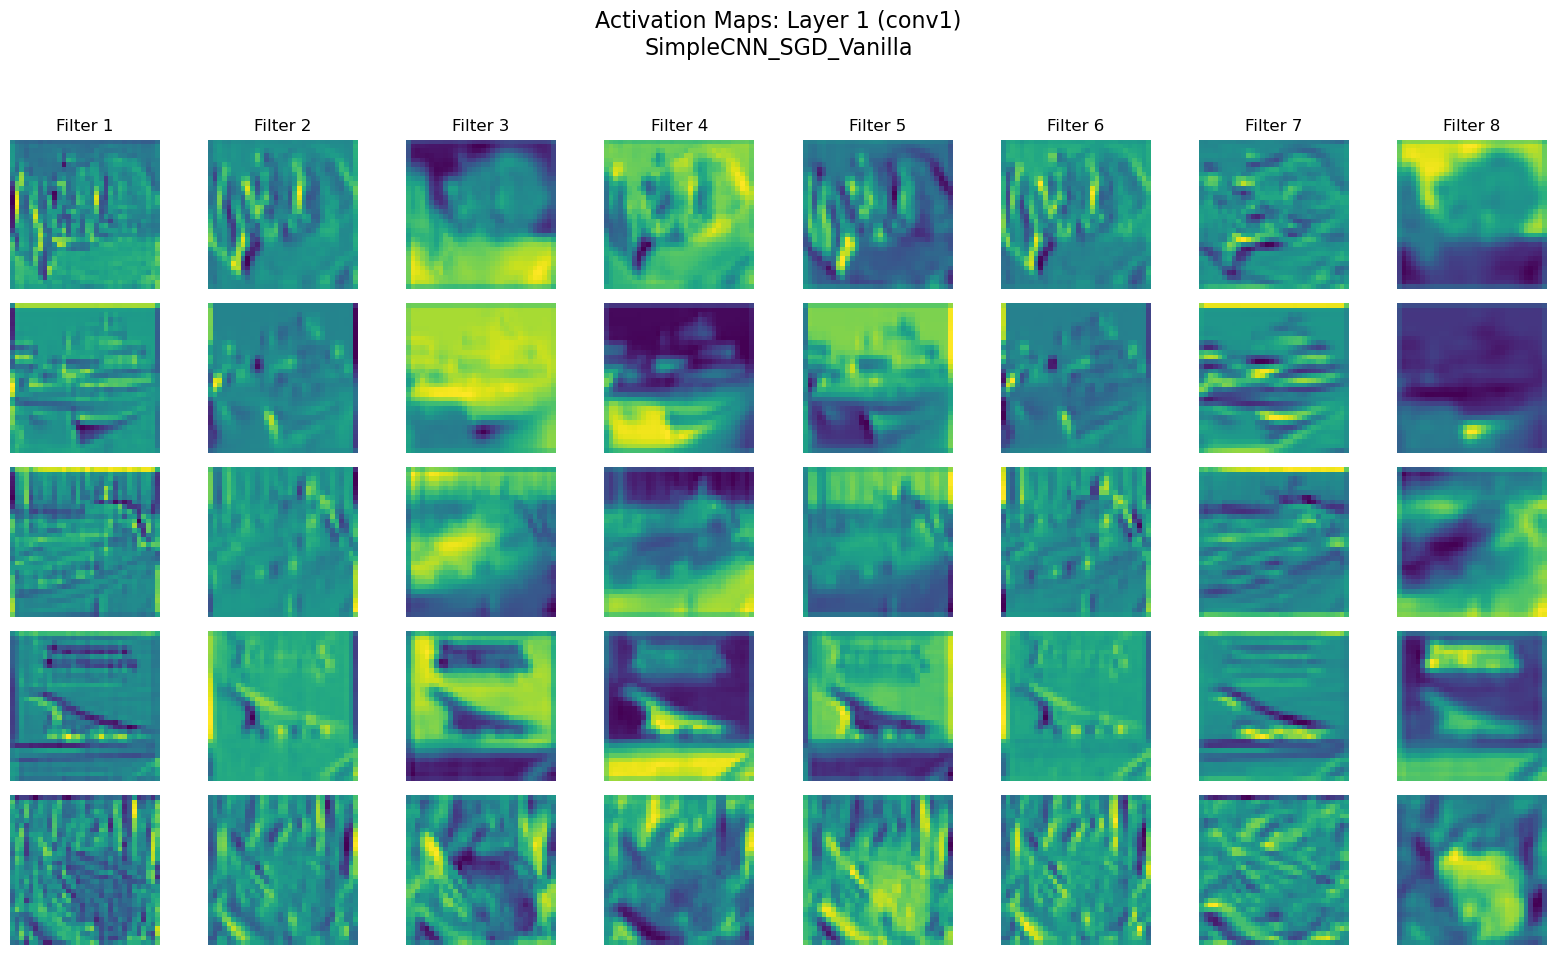

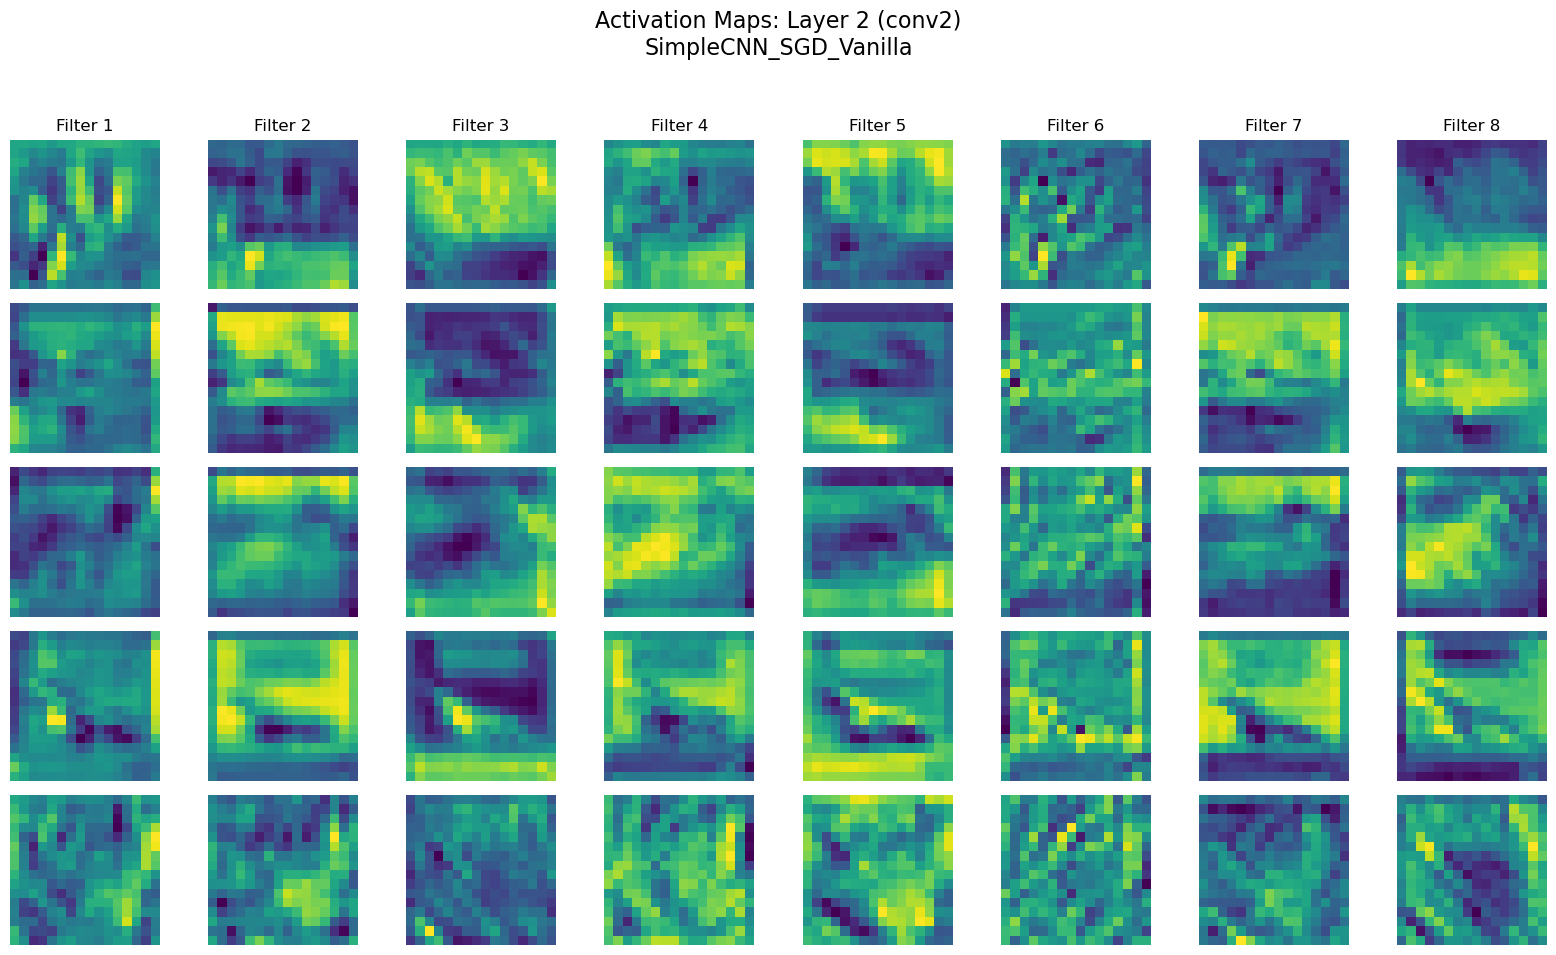

Analyzing: SimpleCNN_SGD_Momentum
[Plotting] Training History for SimpleCNN_SGD_Momentum...


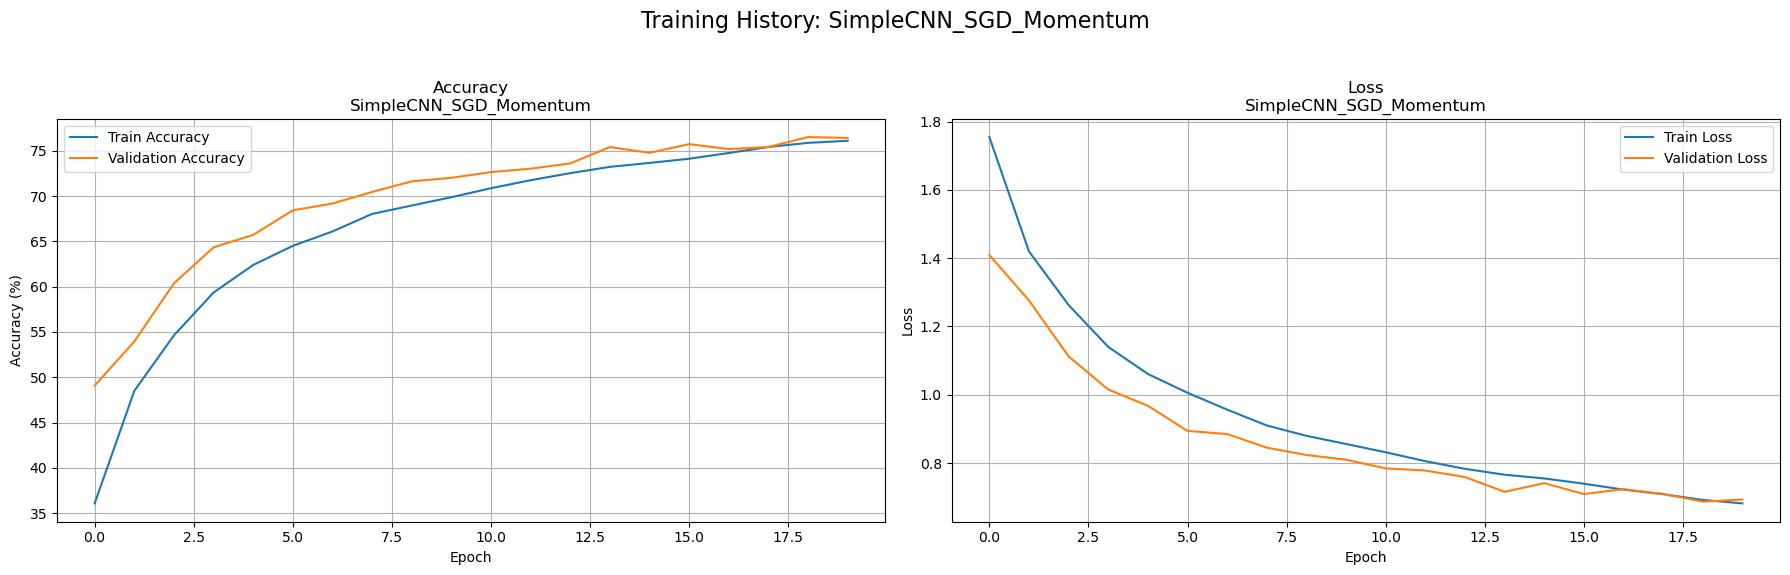

[Evaluating] Final model for SimpleCNN_SGD_Momentum...
[Plotting] Confusion Matrix for SimpleCNN_SGD_Momentum...


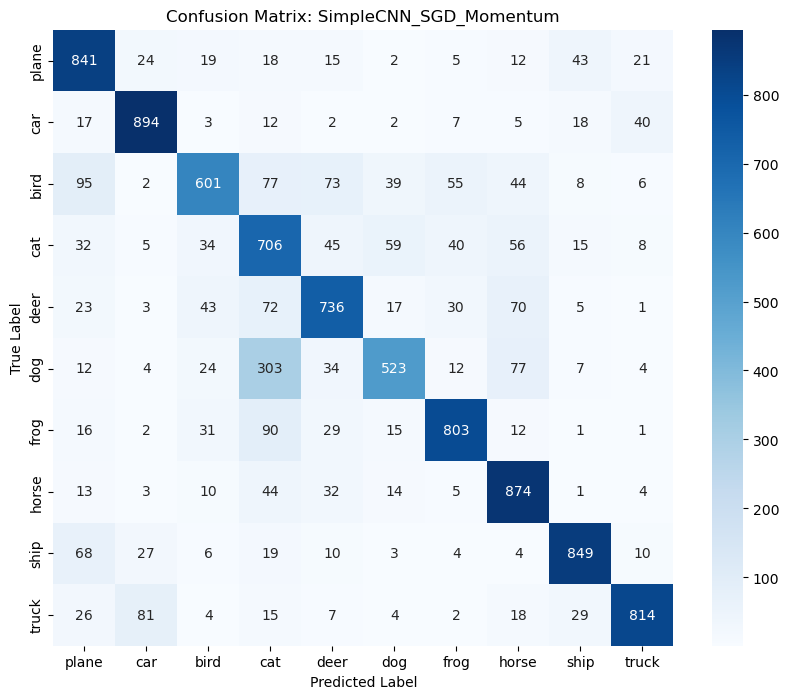

[Plotting] Misclassified Images for SimpleCNN_SGD_Momentum...


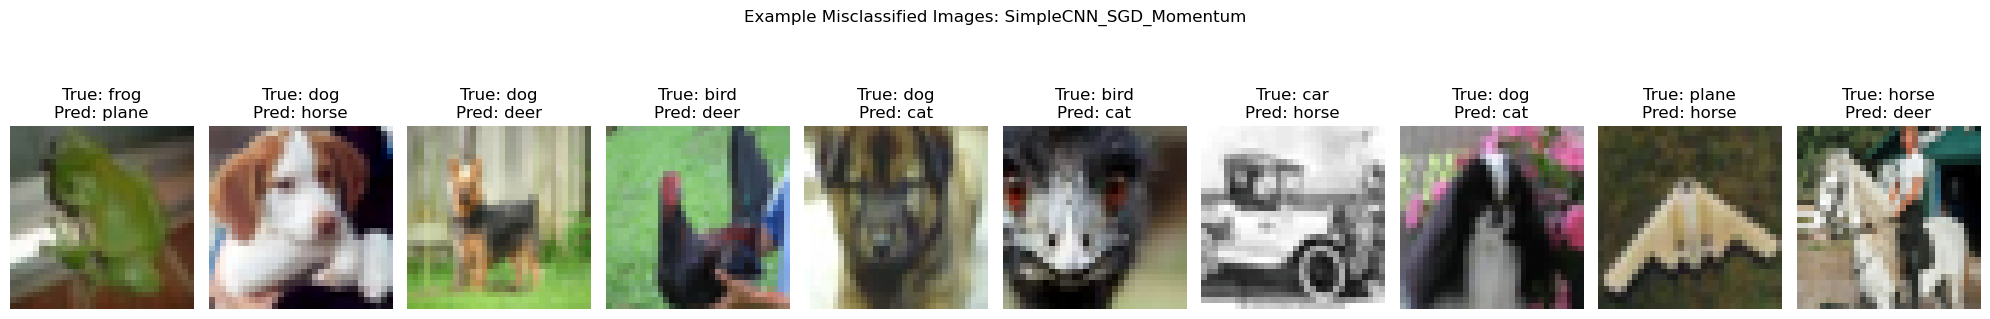

[Plotting] Activation Maps for SimpleCNN_SGD_Momentum...


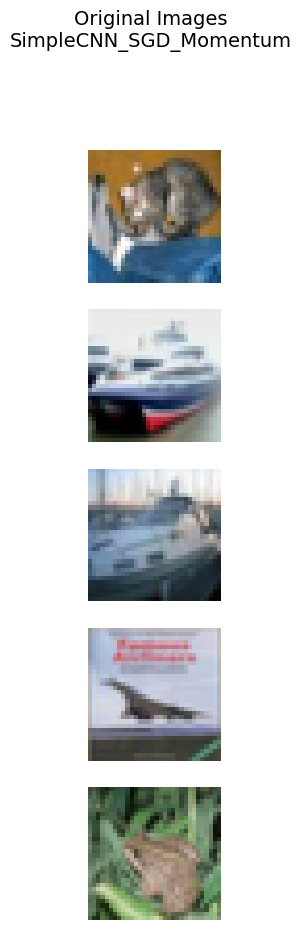

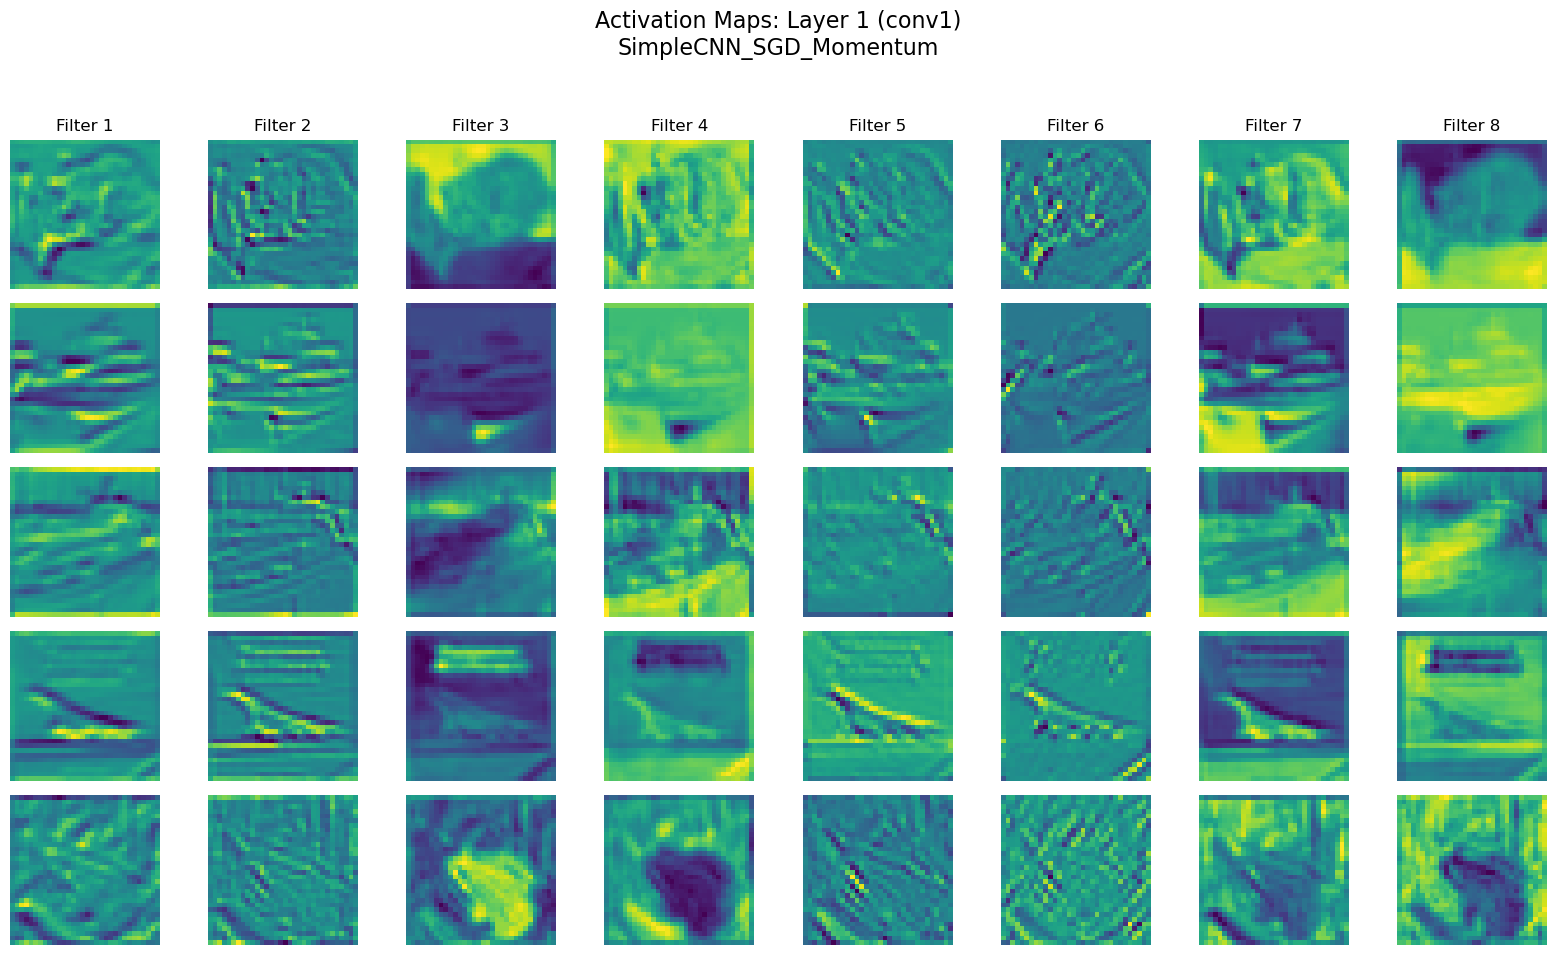

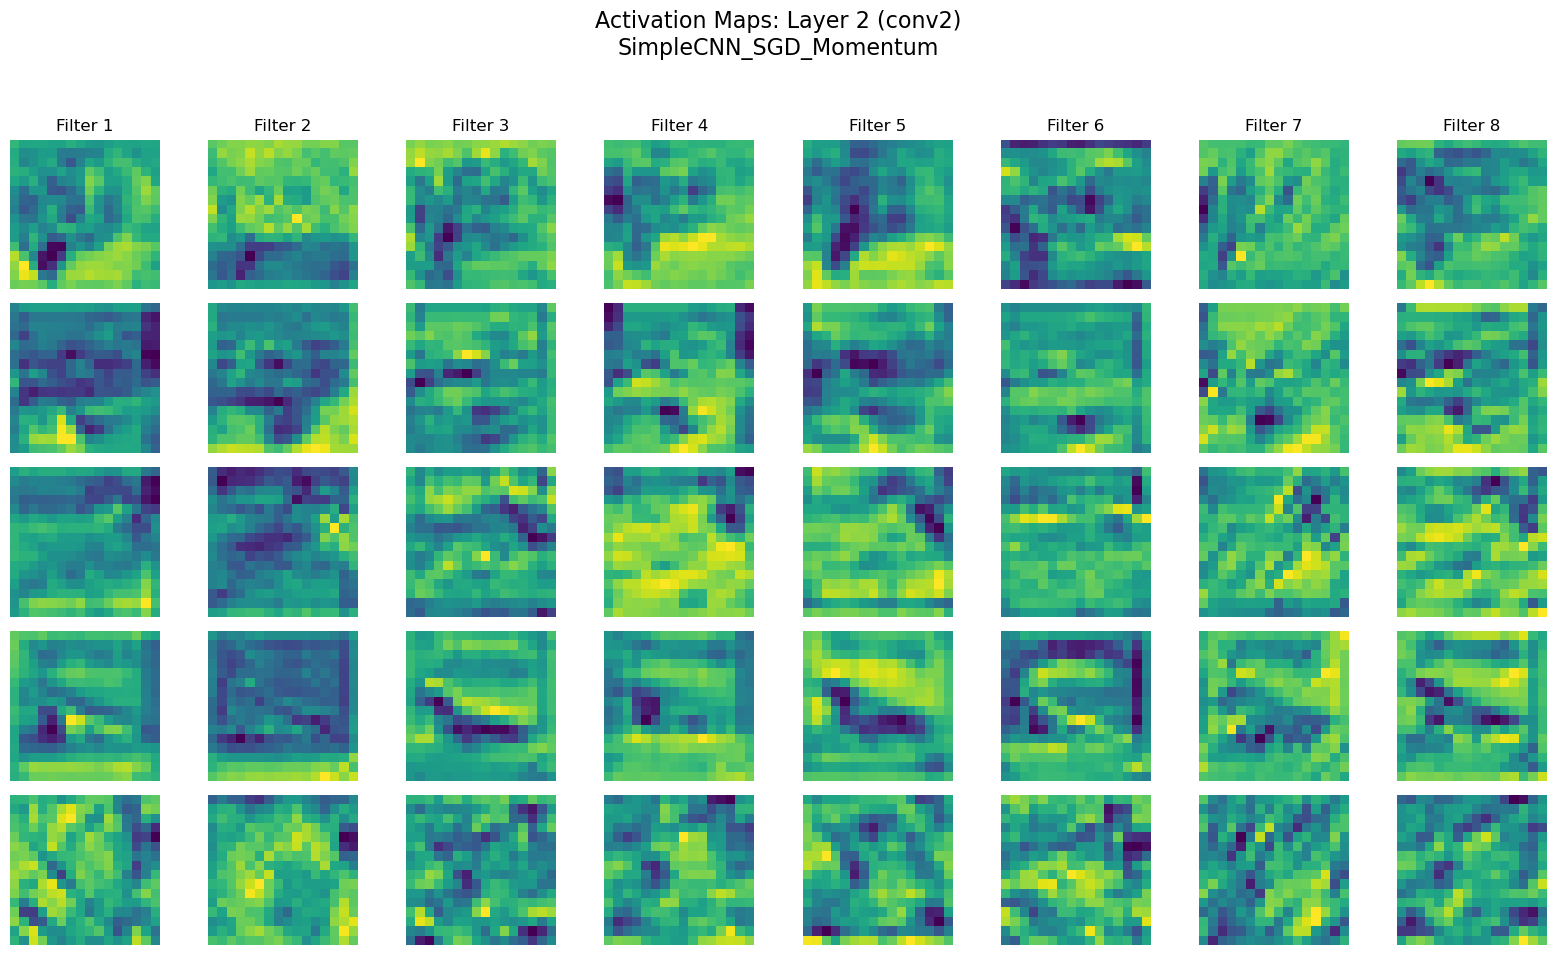

Analyzing: SimpleCNN_SGD_Nesterov
[Plotting] Training History for SimpleCNN_SGD_Nesterov...


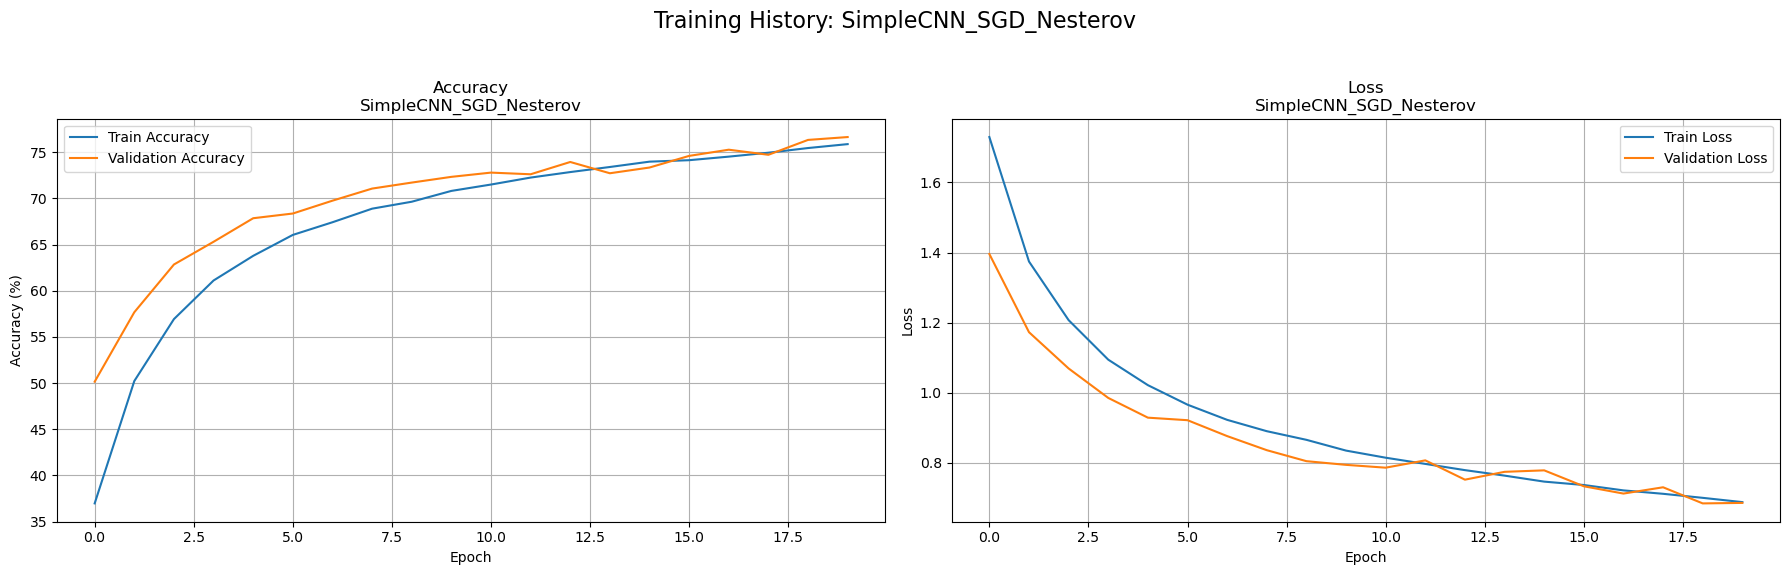

[Evaluating] Final model for SimpleCNN_SGD_Nesterov...
[Plotting] Confusion Matrix for SimpleCNN_SGD_Nesterov...


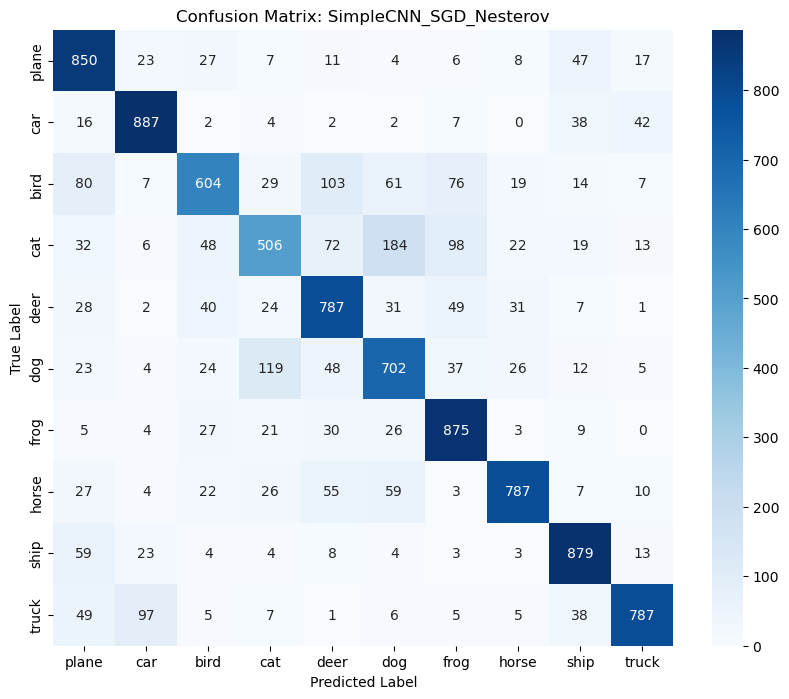

[Plotting] Misclassified Images for SimpleCNN_SGD_Nesterov...


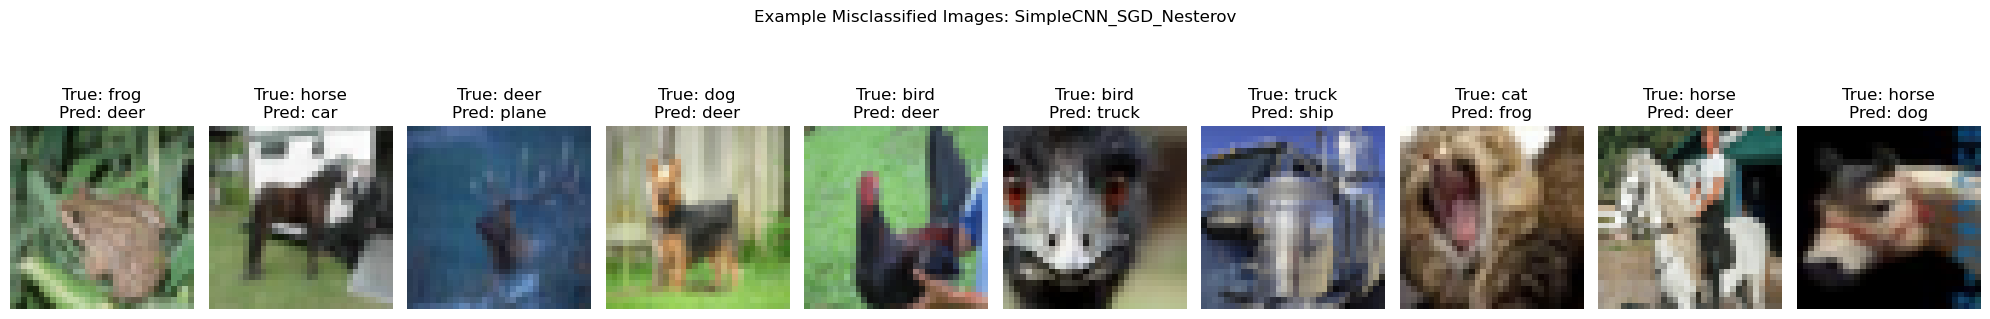

[Plotting] Activation Maps for SimpleCNN_SGD_Nesterov...


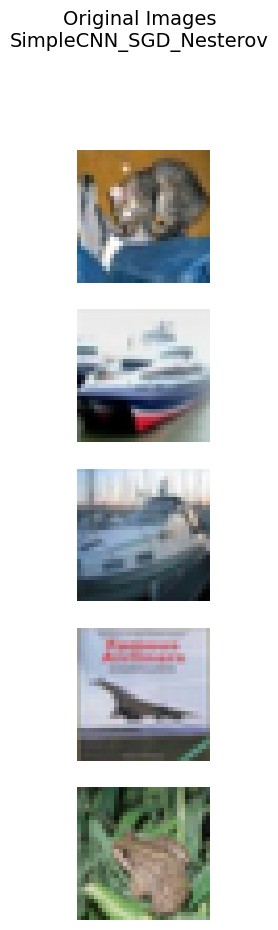

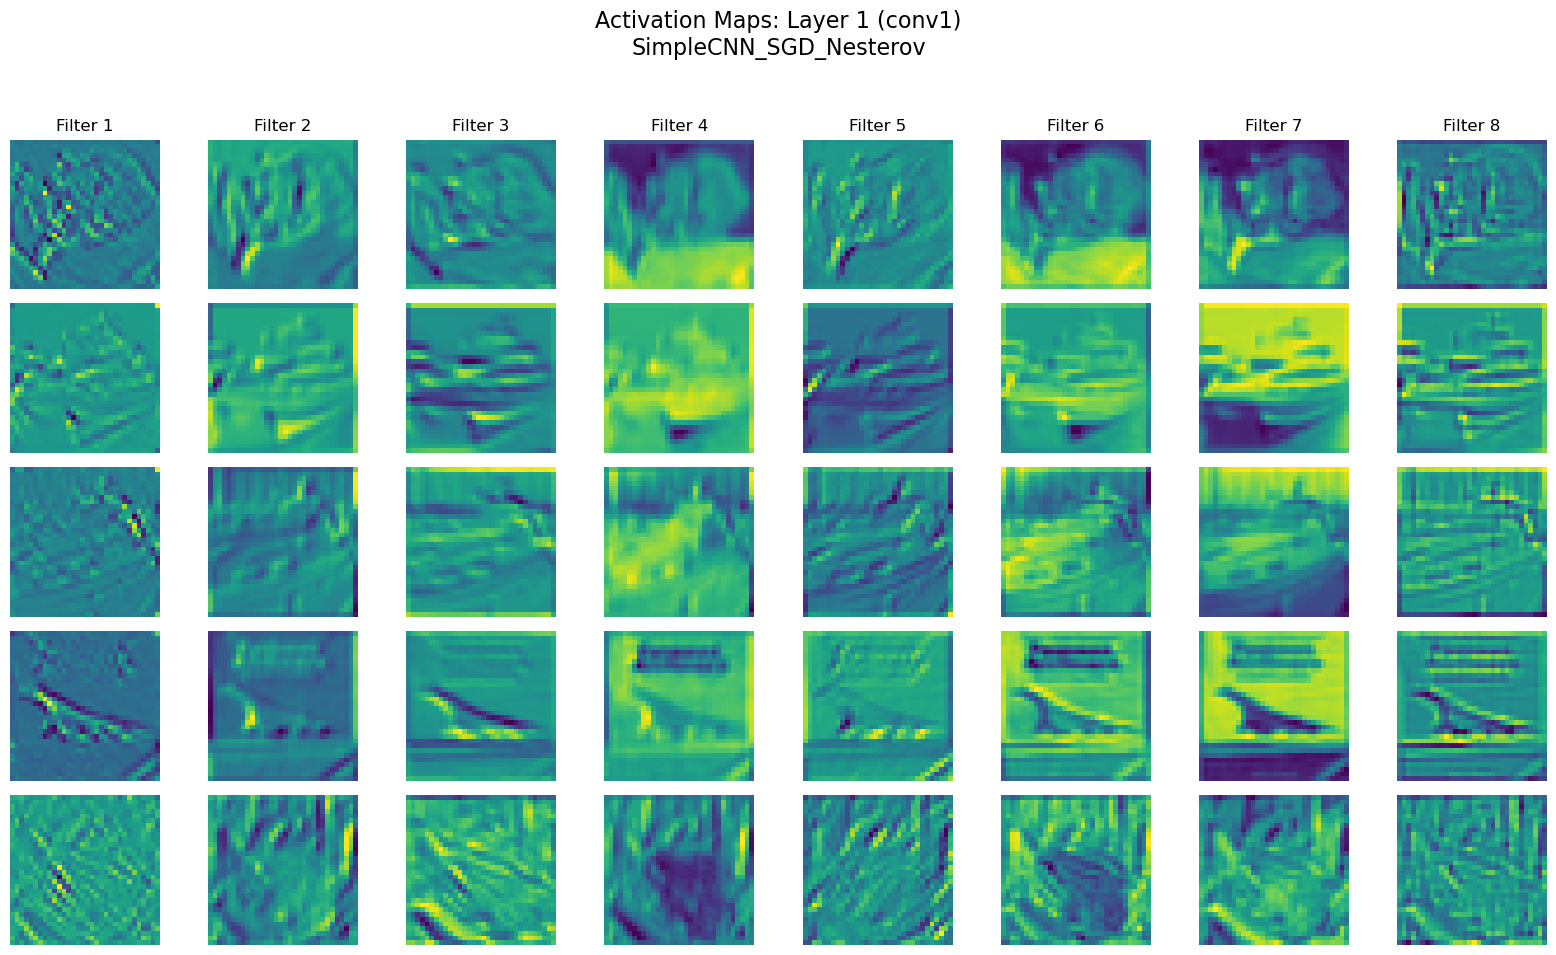

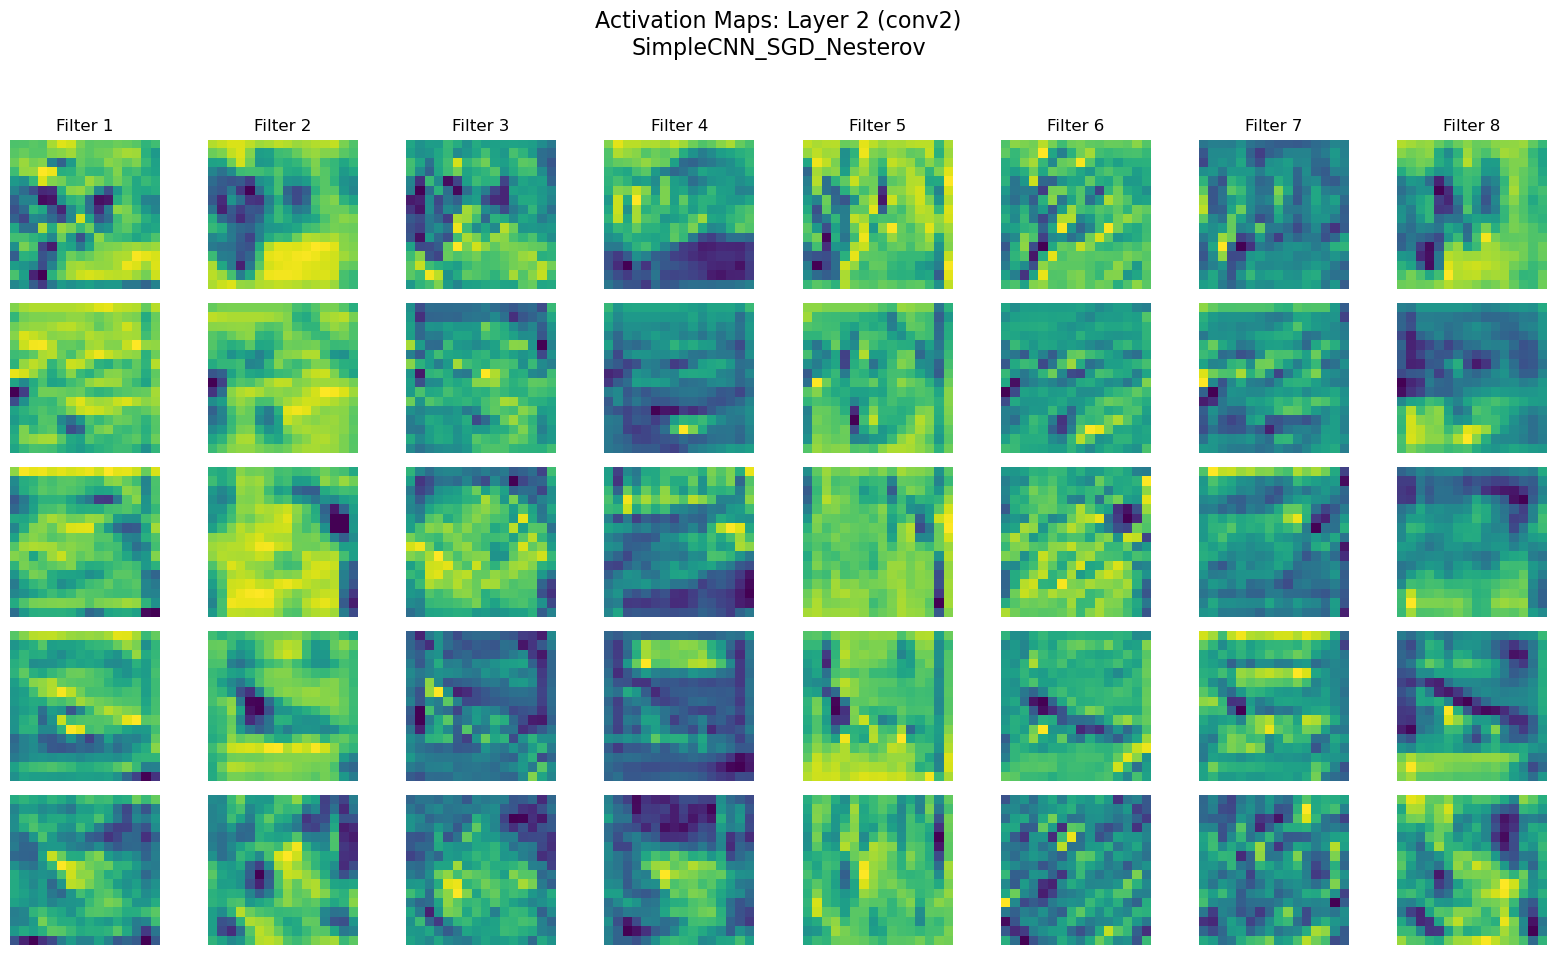

Analyzing: ResNet-18_Adam
[Plotting] Training History for ResNet-18_Adam...


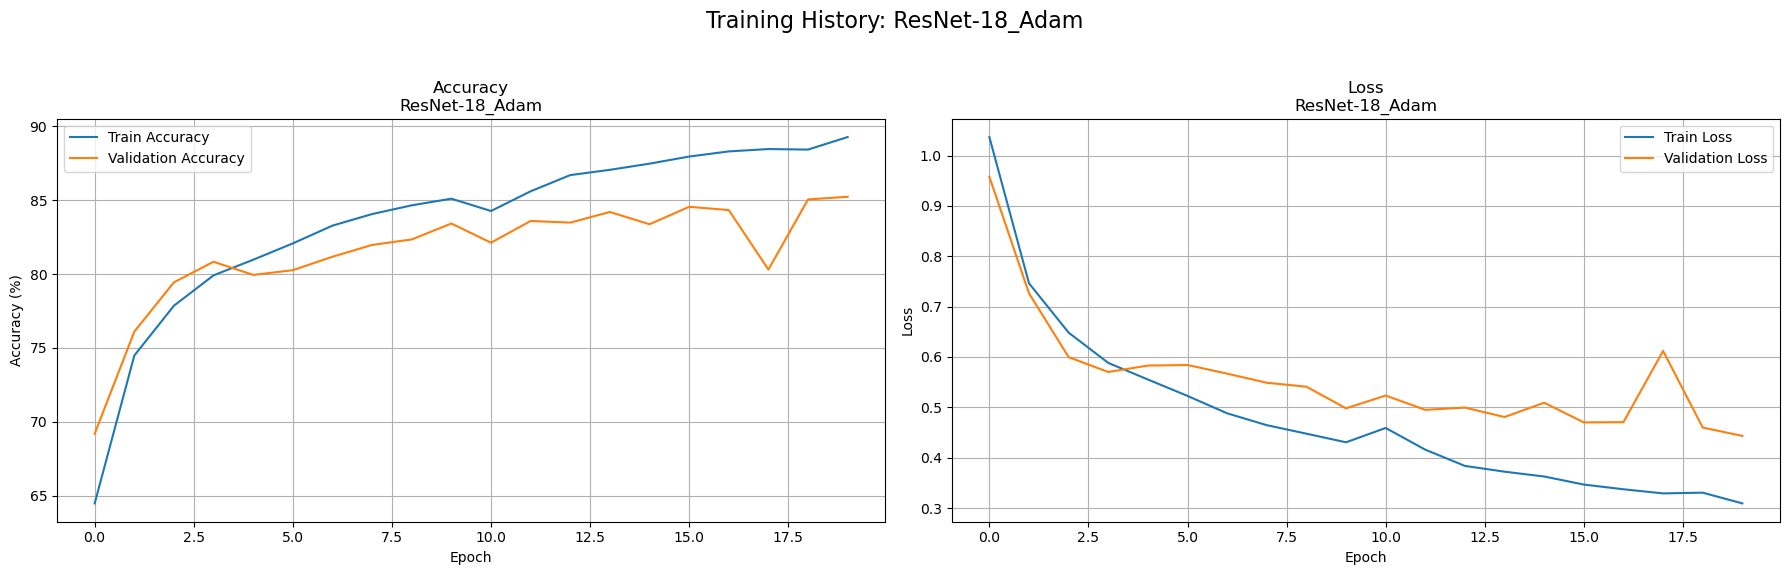

[Evaluating] Final model for ResNet-18_Adam...
[Plotting] Confusion Matrix for ResNet-18_Adam...


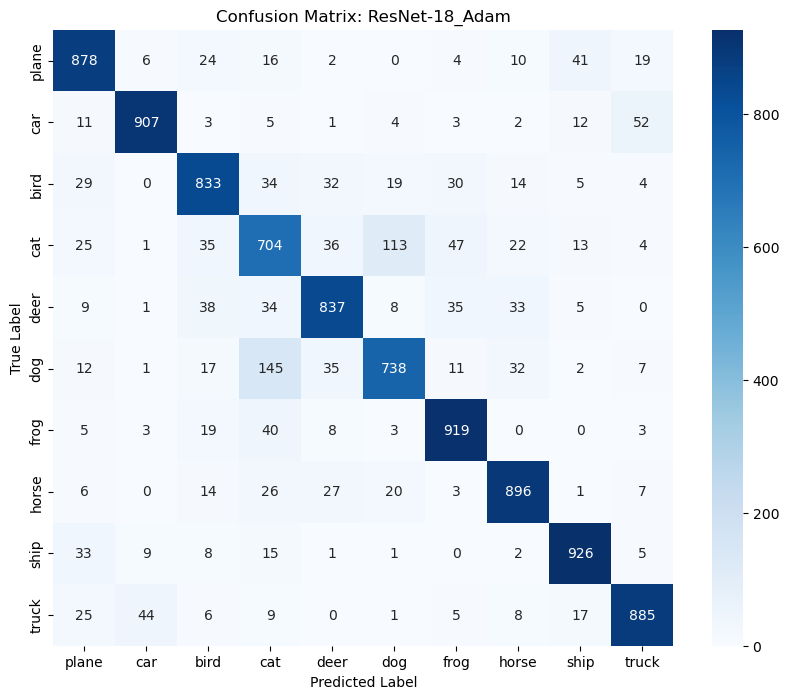

[Plotting] Misclassified Images for ResNet-18_Adam...


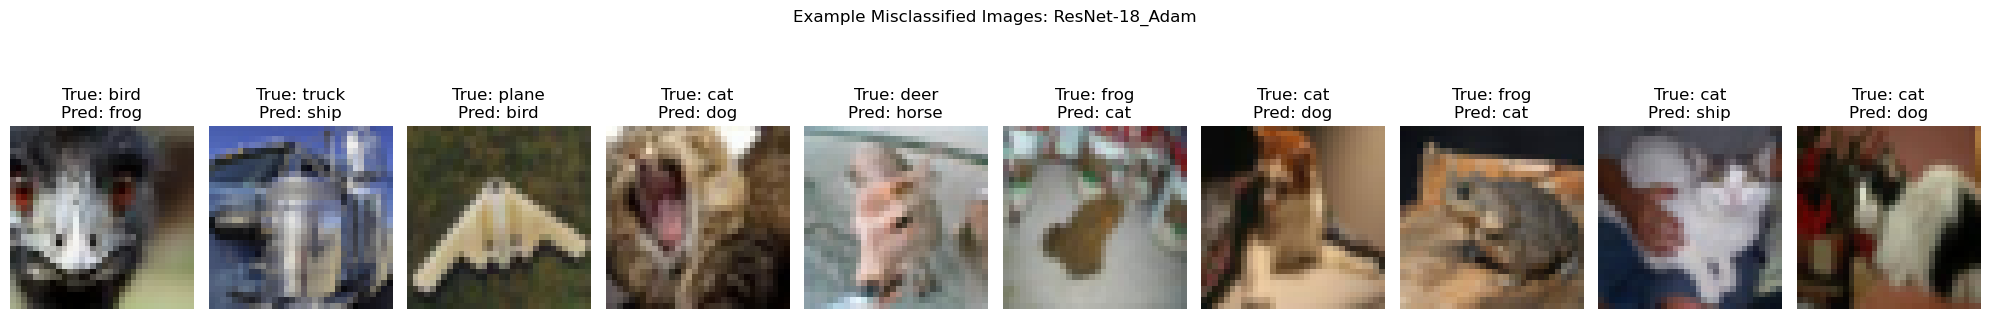

[Plotting] Activation Maps for ResNet-18_Adam...


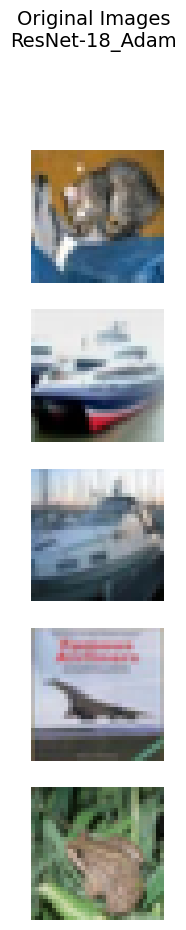

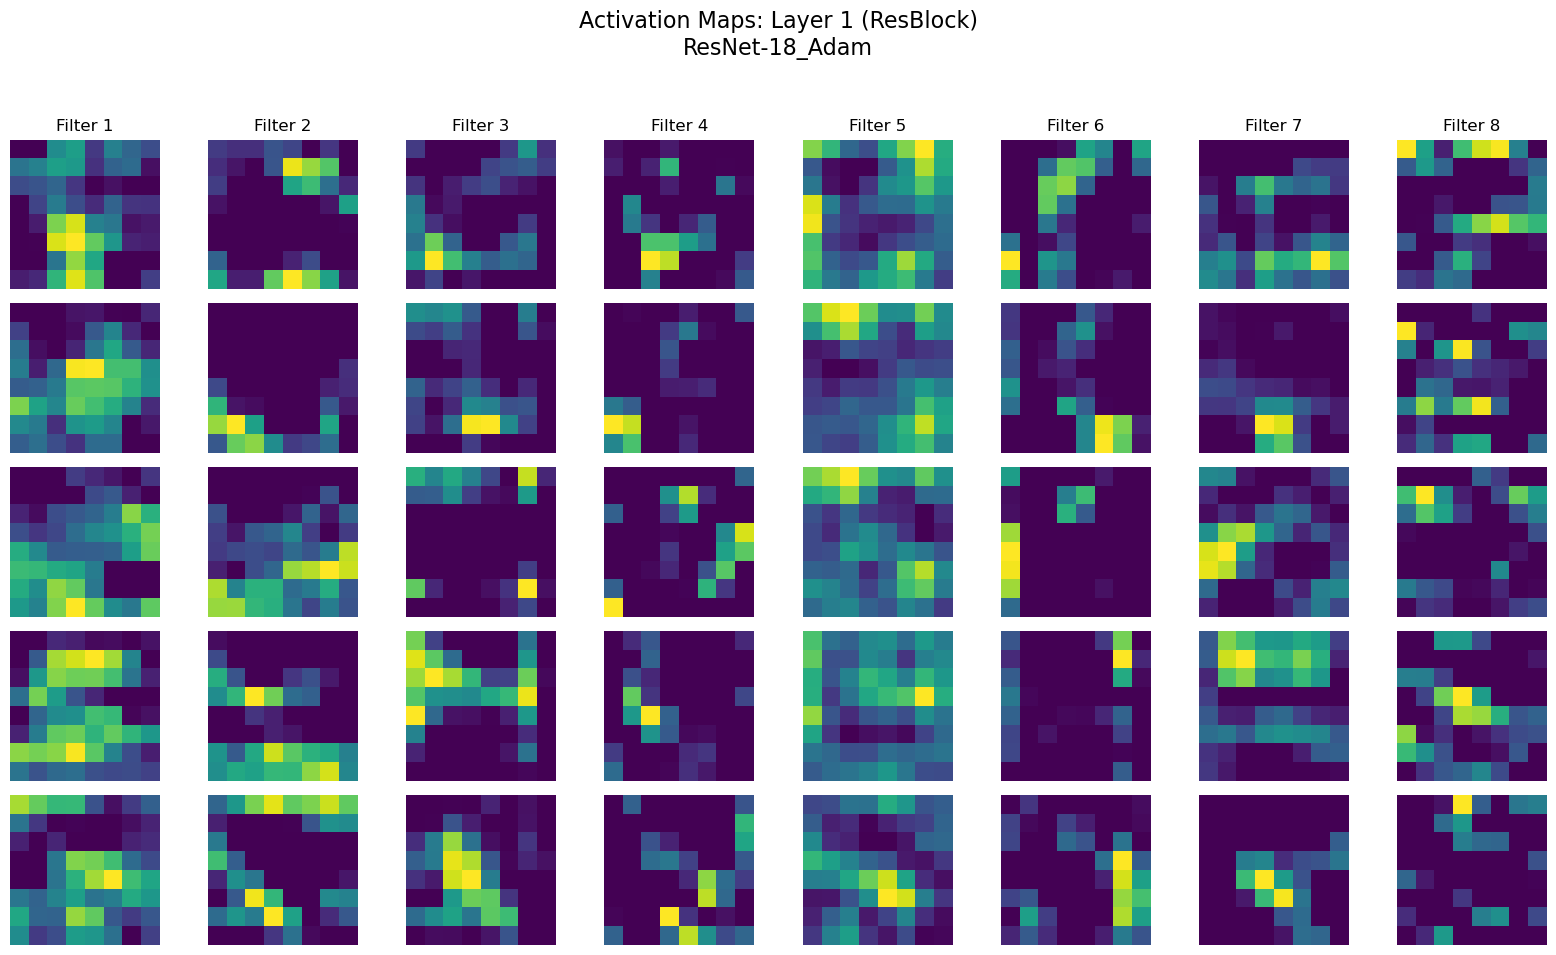

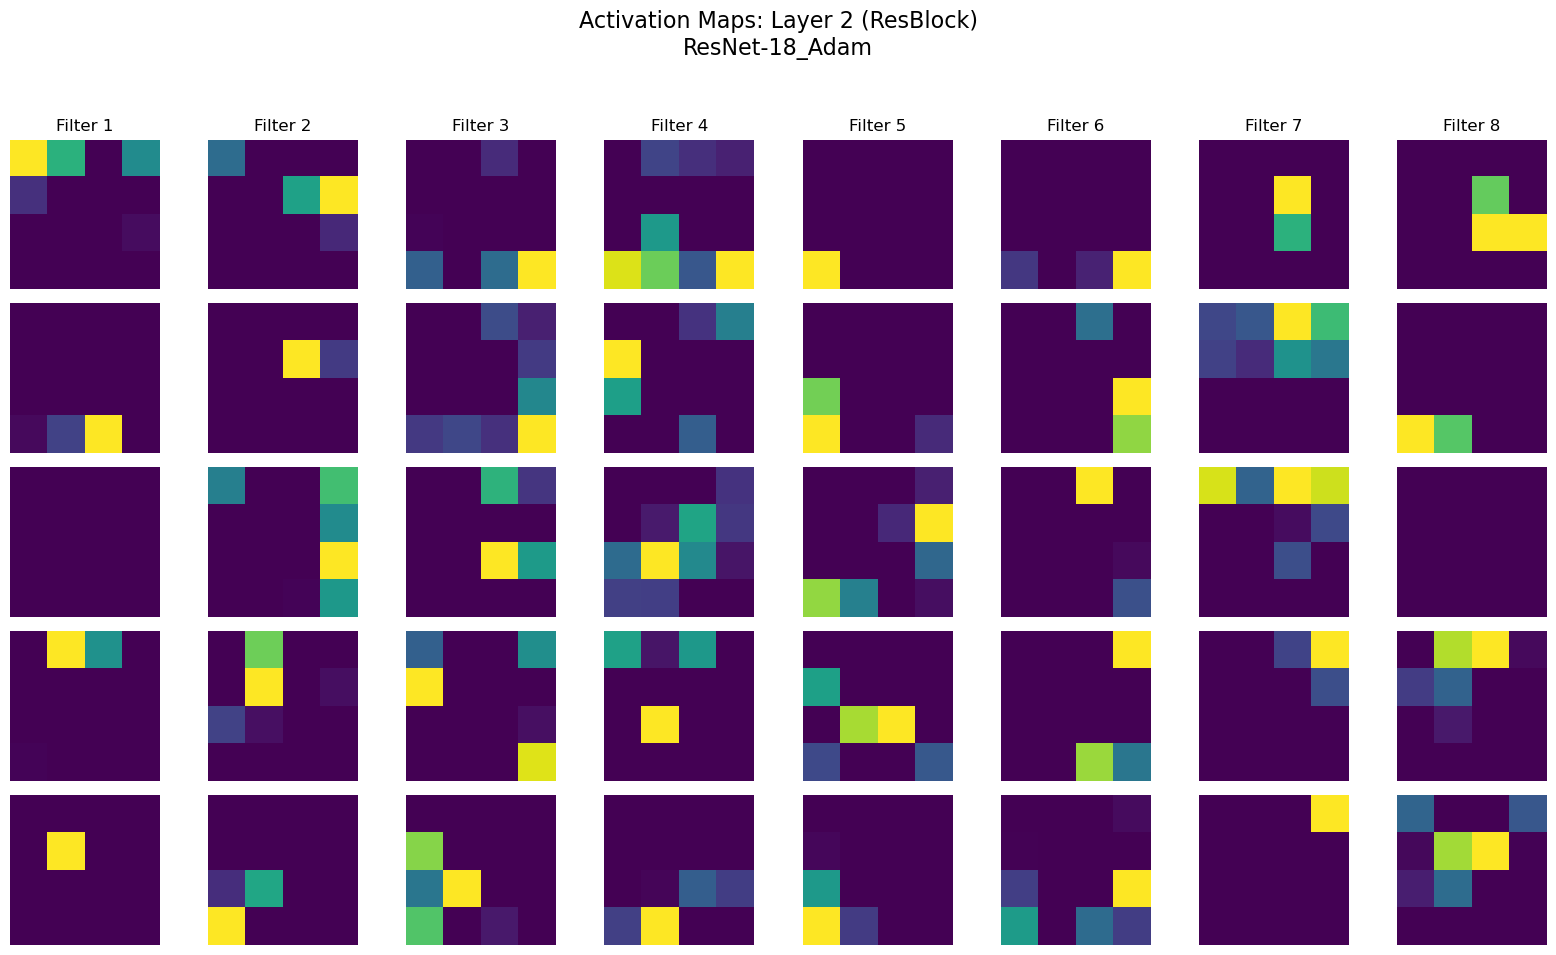

Analyzing: ResNet-18_SGD_Vanilla
[Plotting] Training History for ResNet-18_SGD_Vanilla...


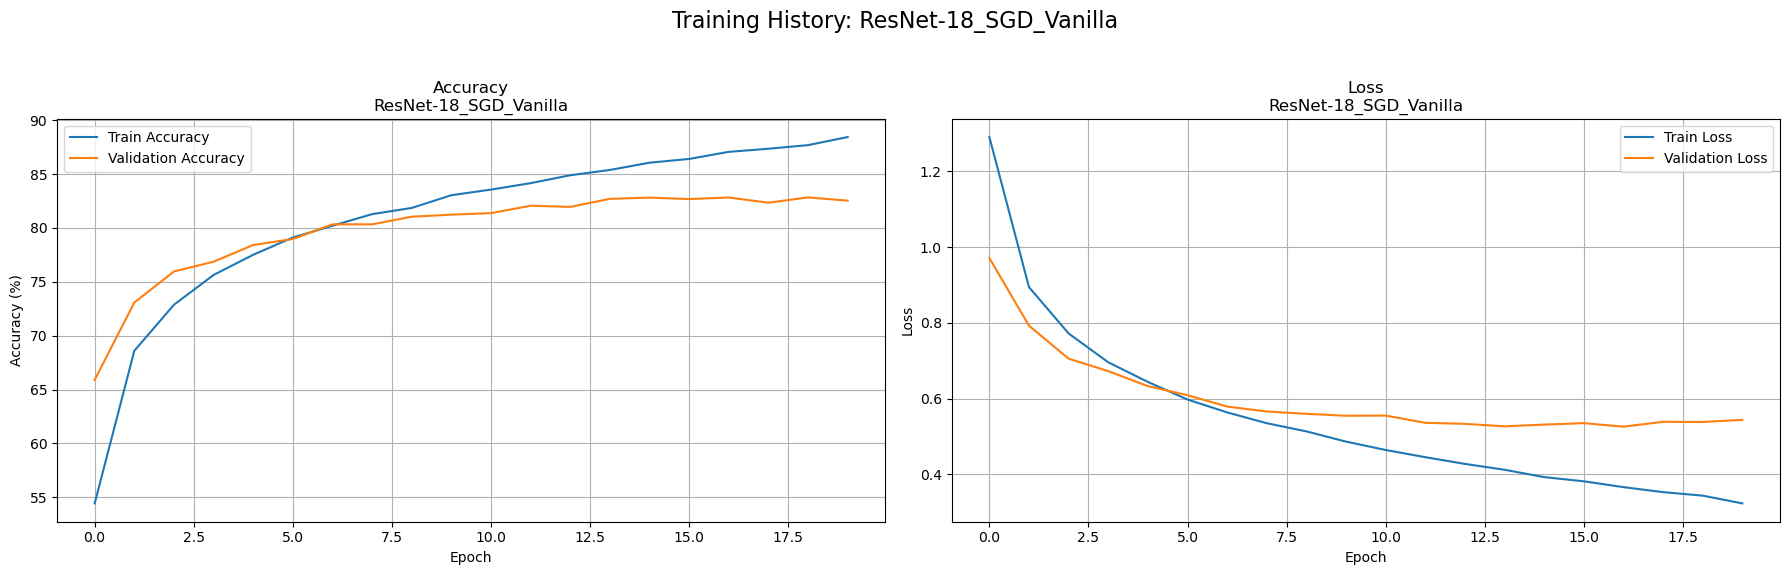

[Evaluating] Final model for ResNet-18_SGD_Vanilla...
[Plotting] Confusion Matrix for ResNet-18_SGD_Vanilla...


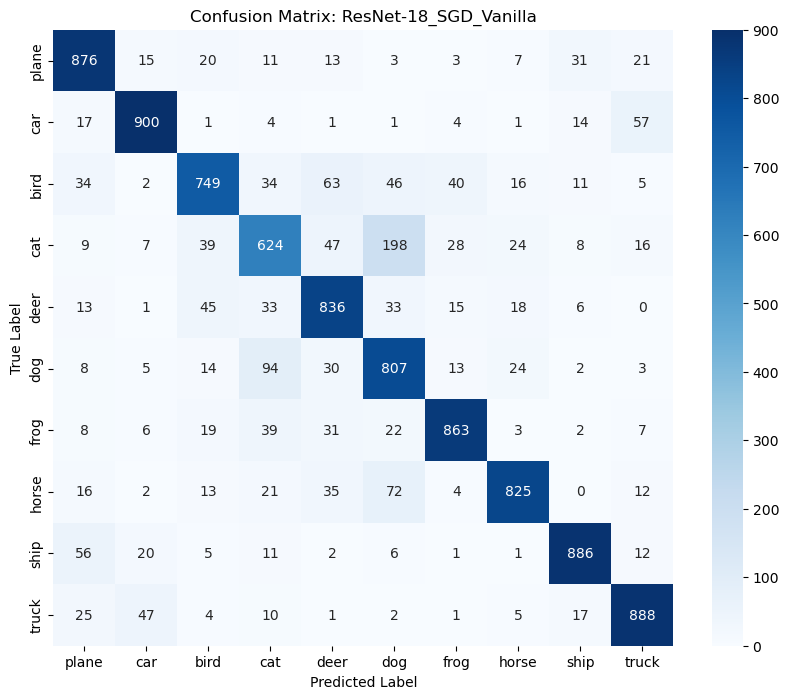

[Plotting] Misclassified Images for ResNet-18_SGD_Vanilla...


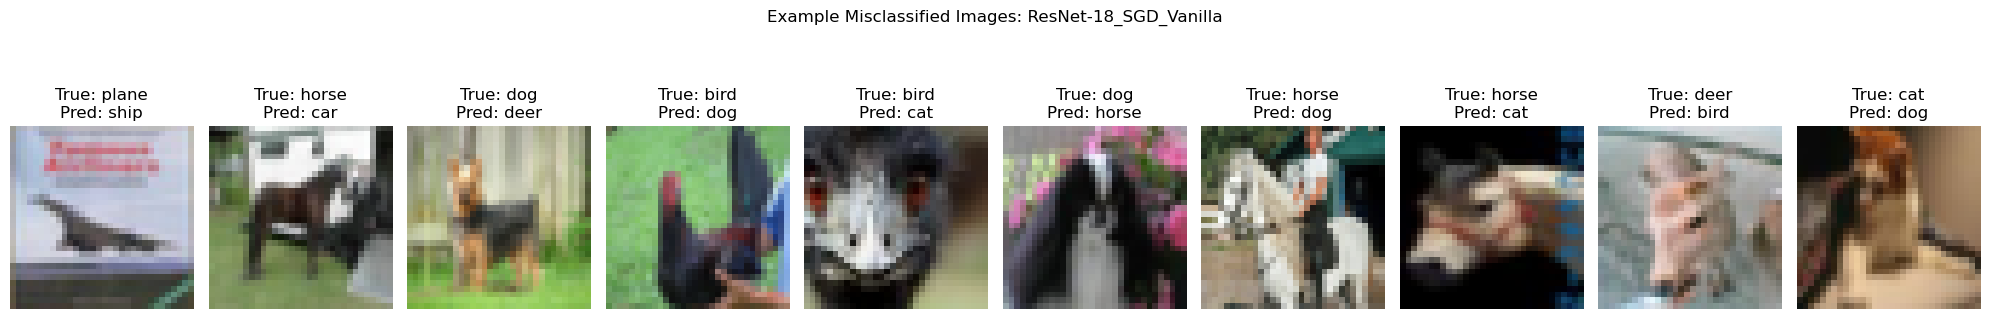

[Plotting] Activation Maps for ResNet-18_SGD_Vanilla...


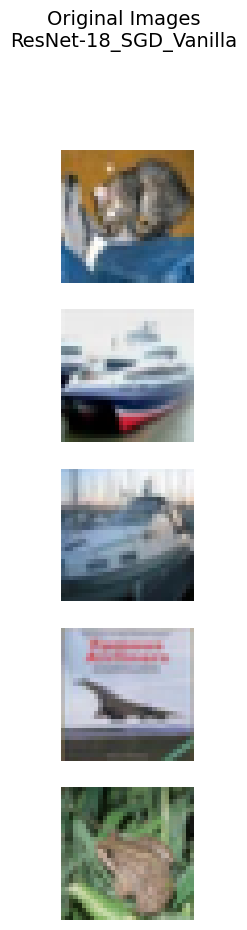

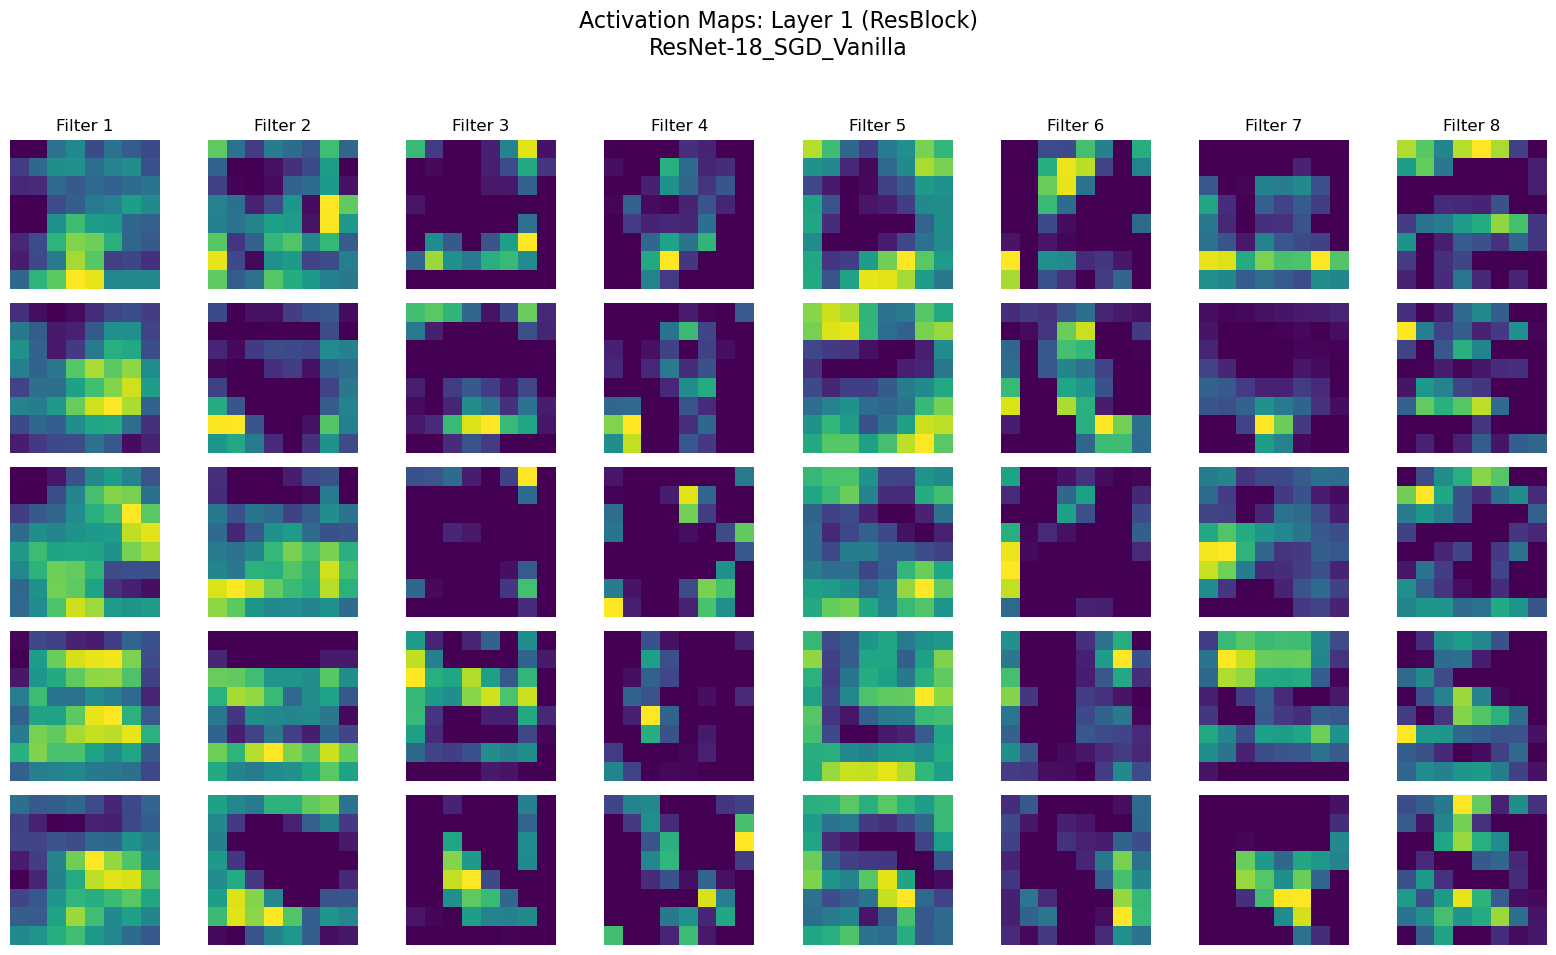

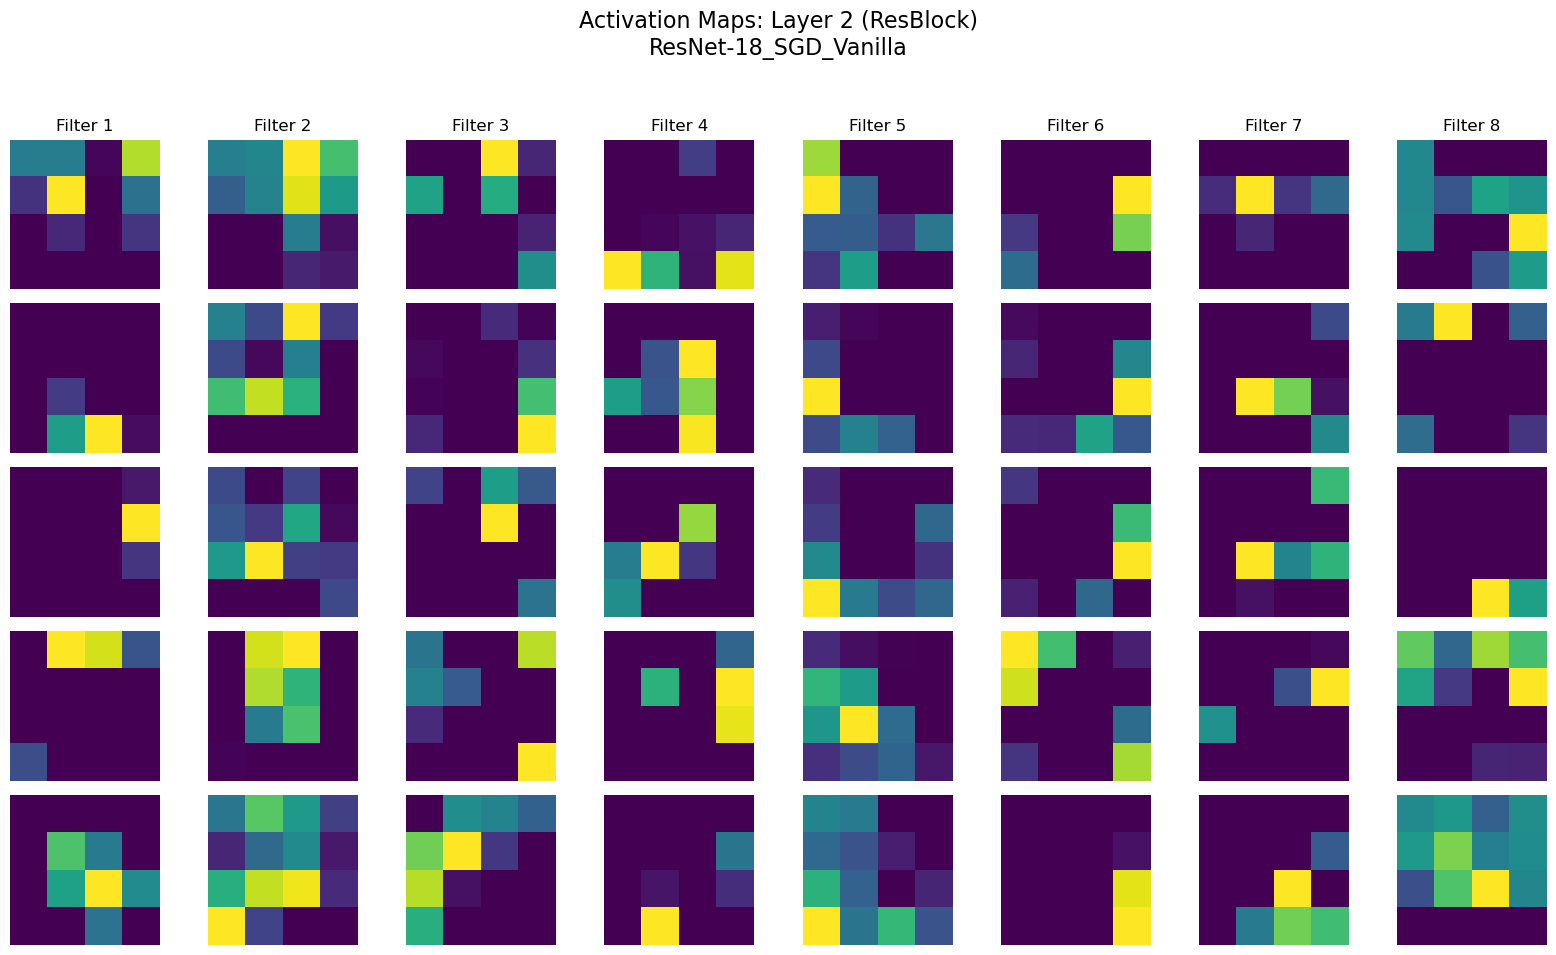

Analyzing: ResNet-18_SGD_Momentum
[Plotting] Training History for ResNet-18_SGD_Momentum...


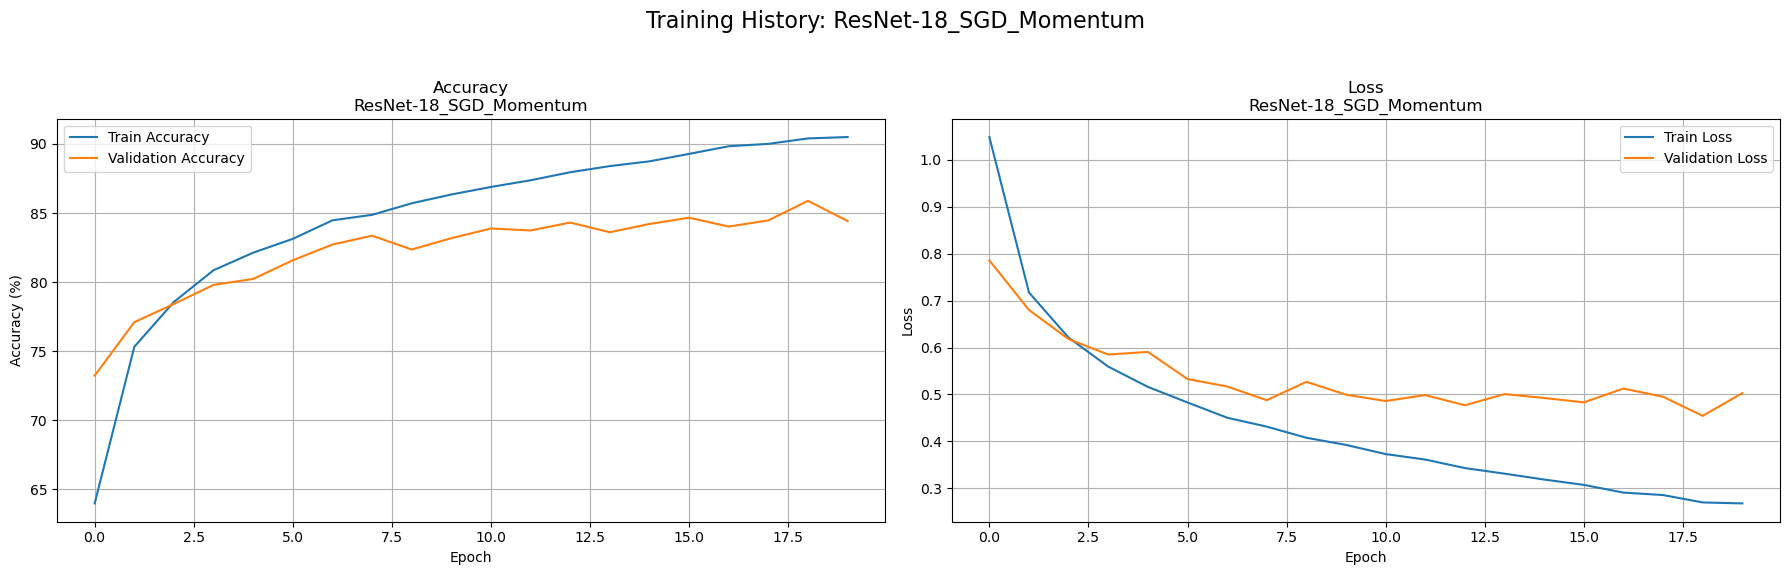

[Evaluating] Final model for ResNet-18_SGD_Momentum...
[Plotting] Confusion Matrix for ResNet-18_SGD_Momentum...


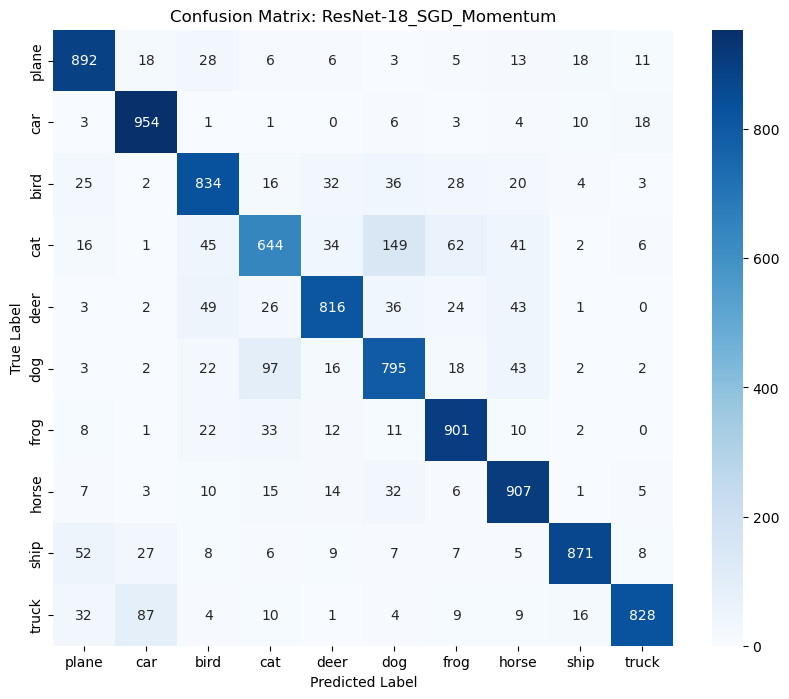

[Plotting] Misclassified Images for ResNet-18_SGD_Momentum...


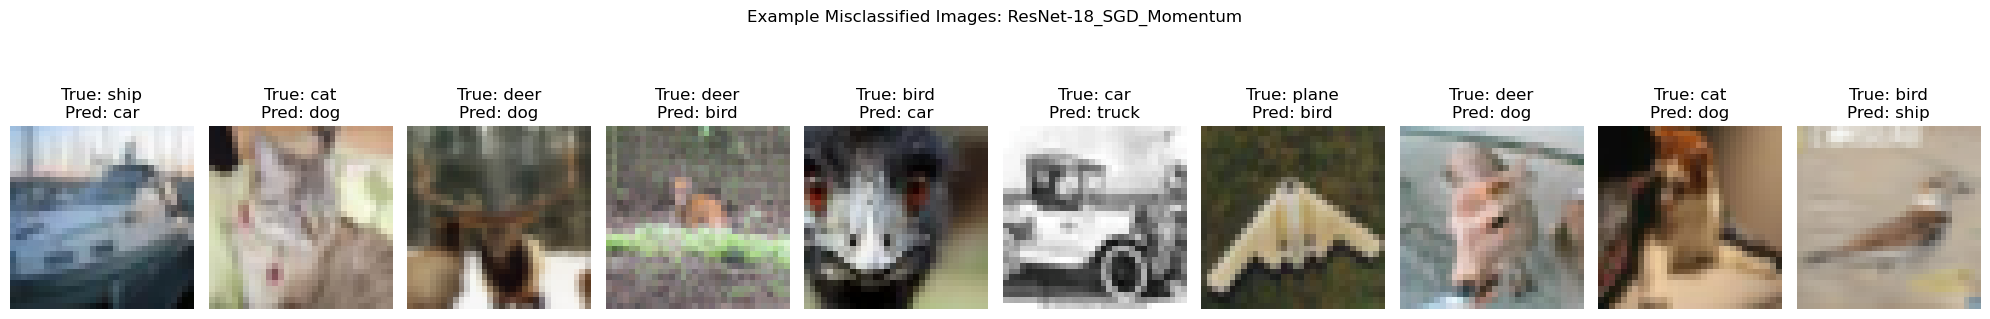

[Plotting] Activation Maps for ResNet-18_SGD_Momentum...


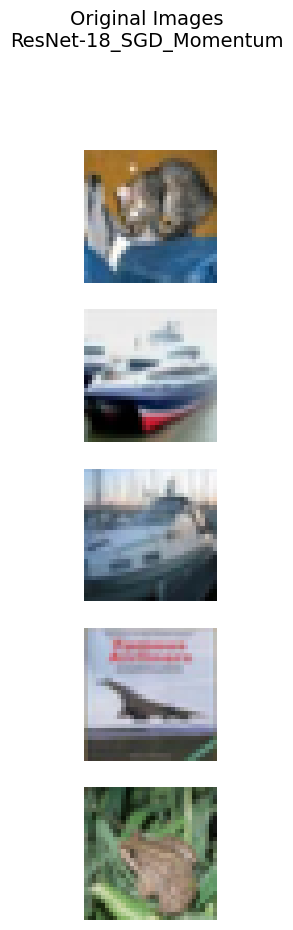

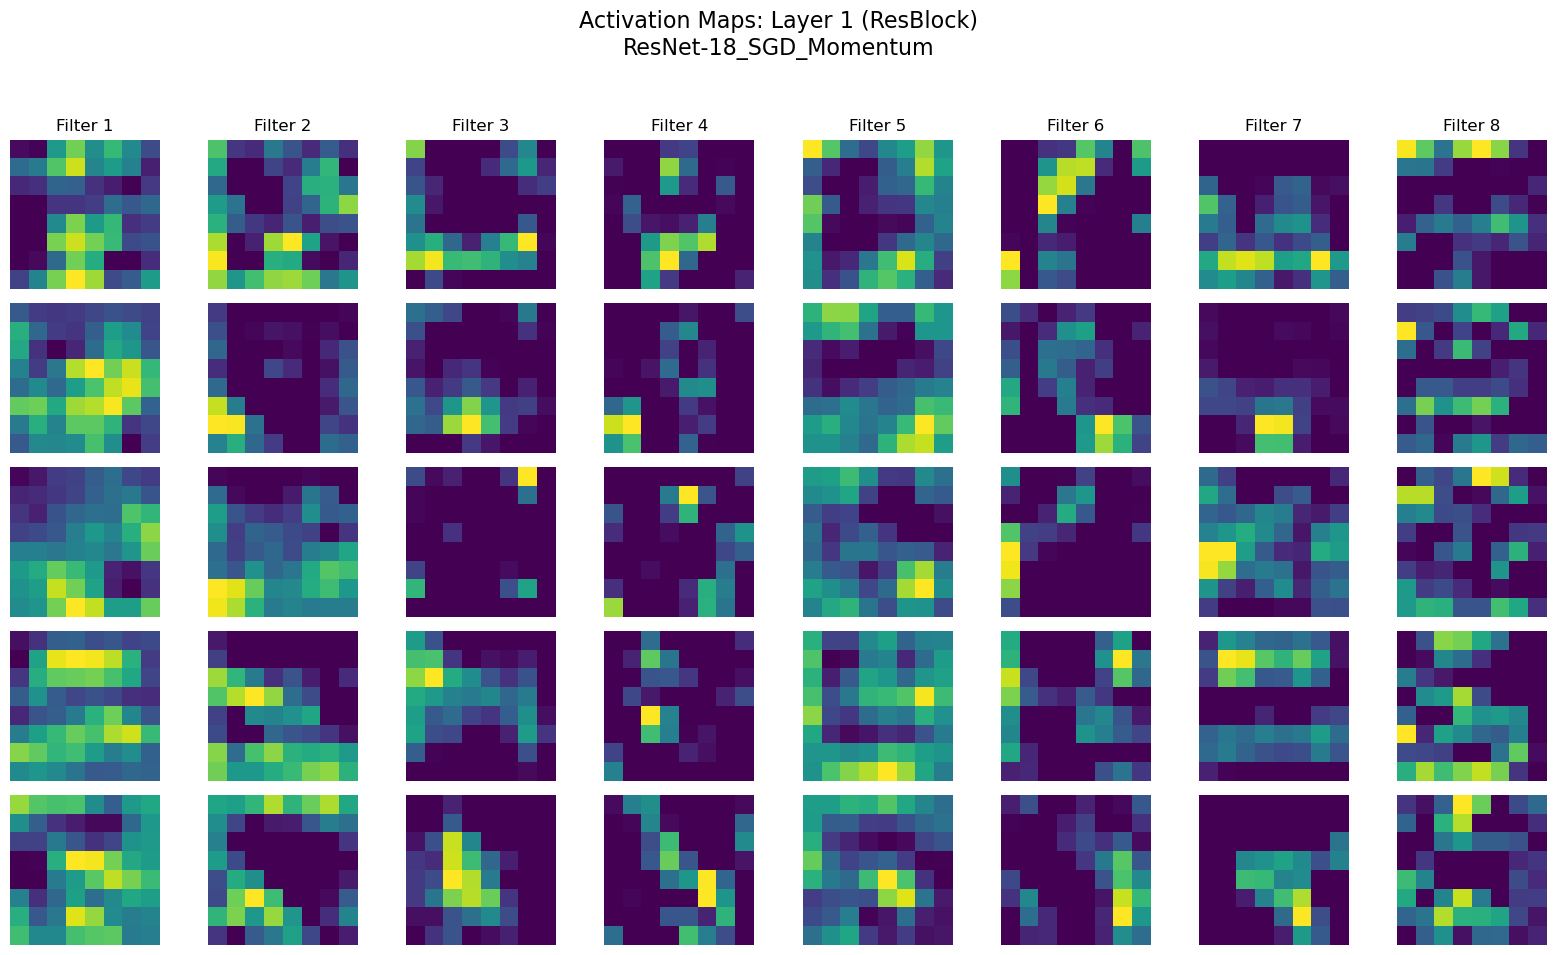

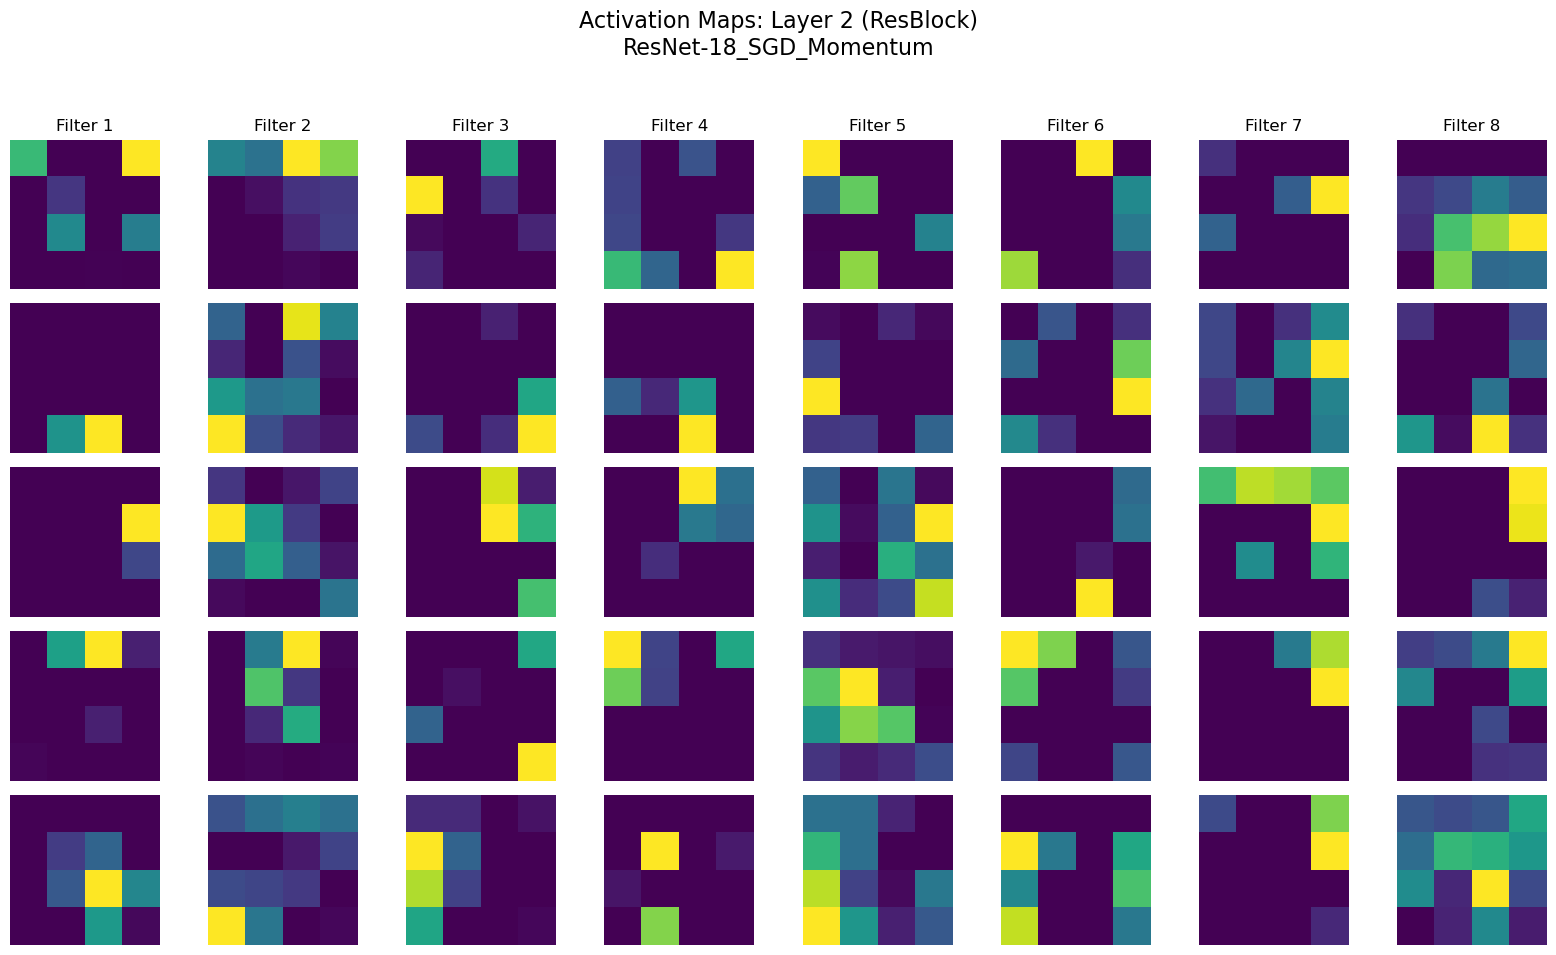

Analyzing: ResNet-18_SGD_Nesterov
[Plotting] Training History for ResNet-18_SGD_Nesterov...


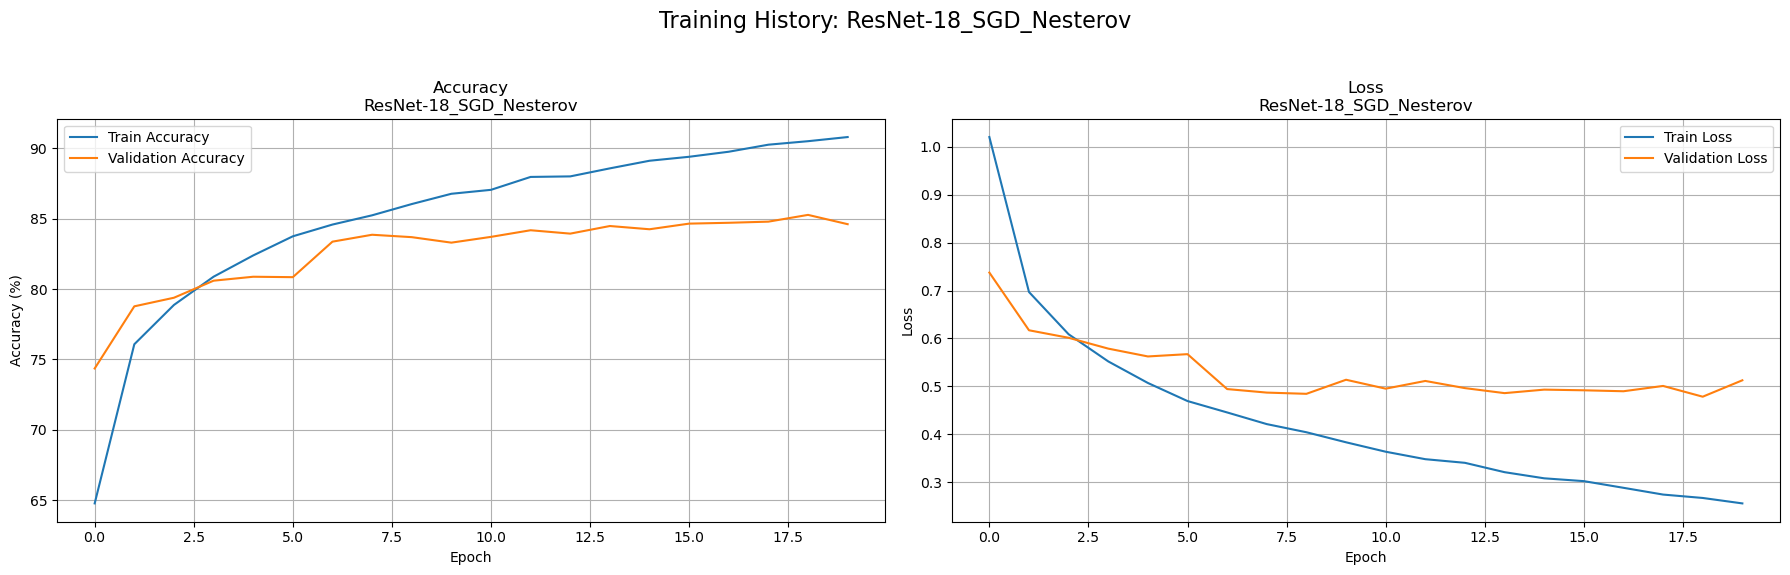

[Evaluating] Final model for ResNet-18_SGD_Nesterov...
[Plotting] Confusion Matrix for ResNet-18_SGD_Nesterov...


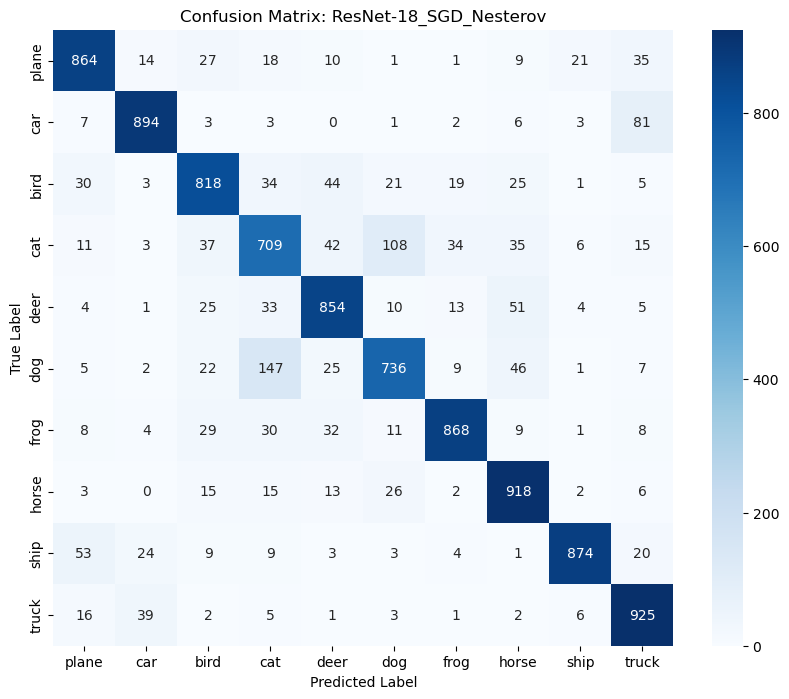

[Plotting] Misclassified Images for ResNet-18_SGD_Nesterov...


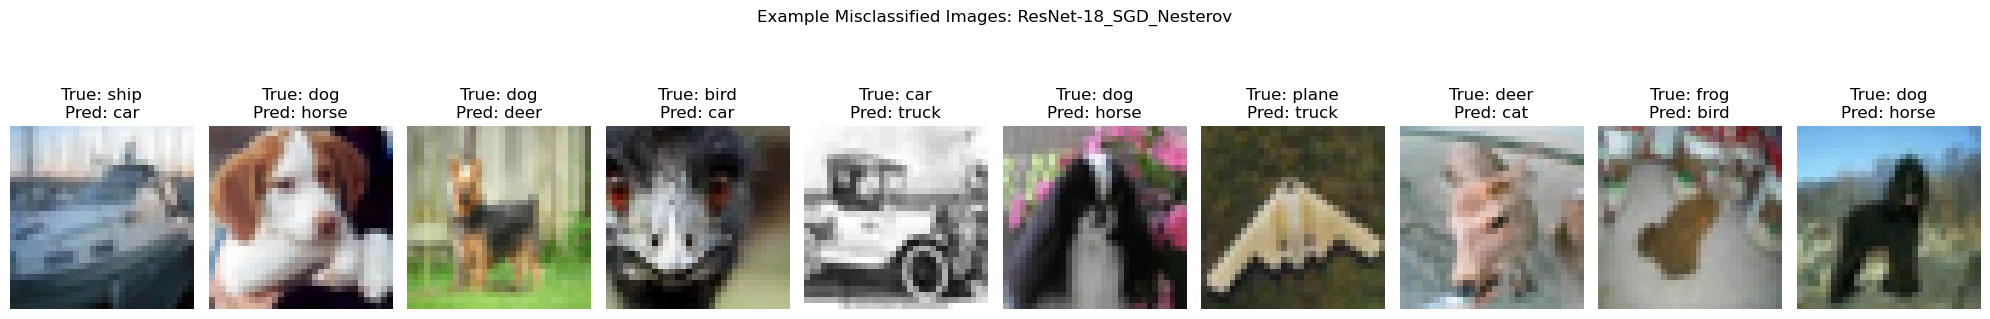

[Plotting] Activation Maps for ResNet-18_SGD_Nesterov...


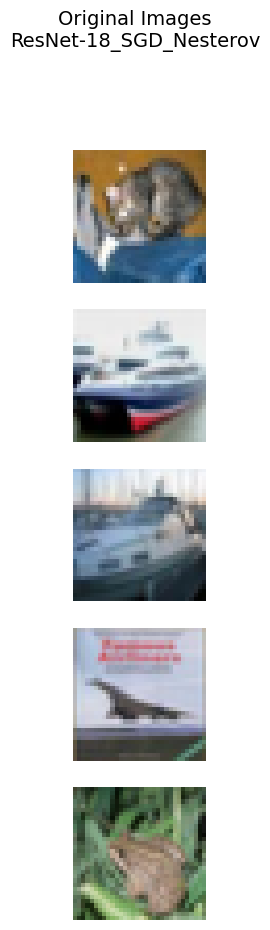

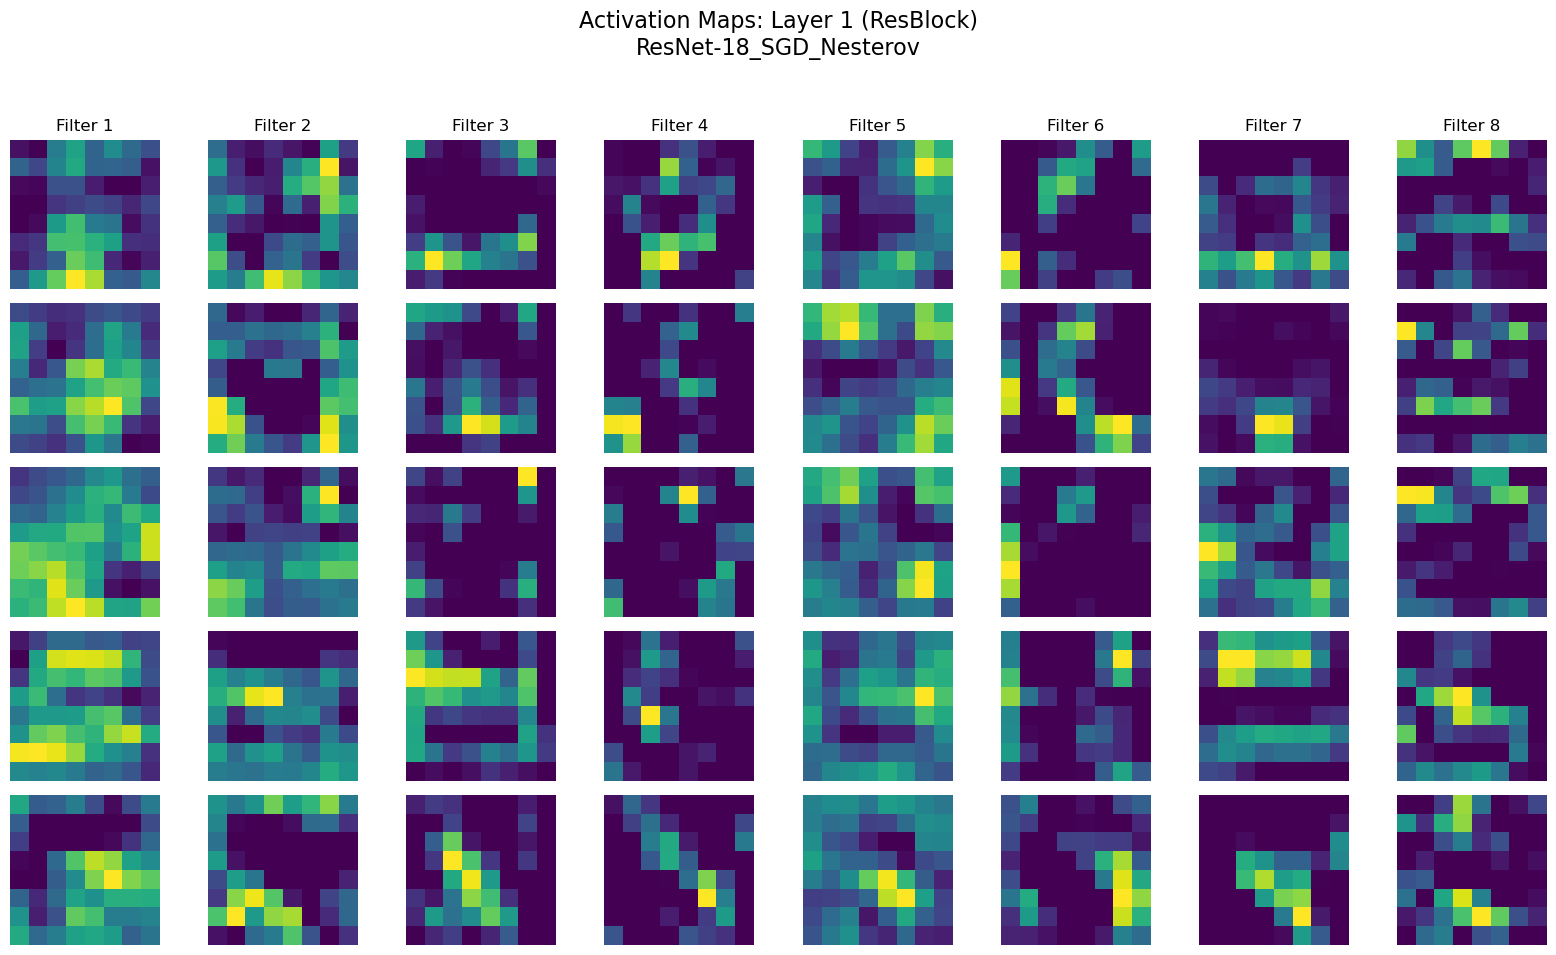

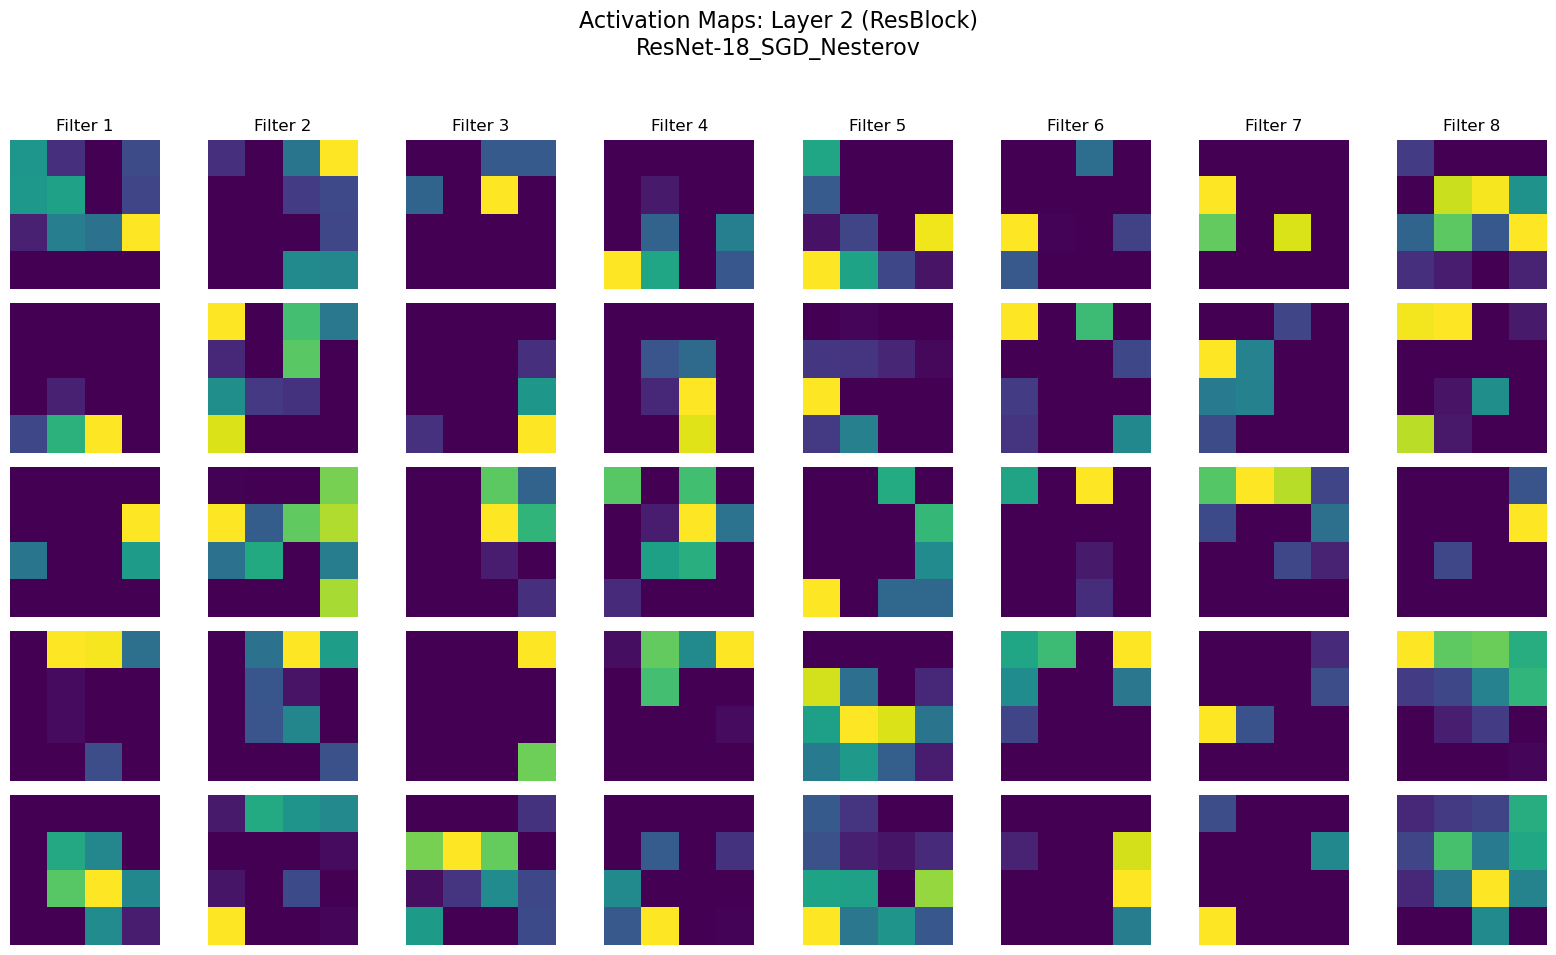

In [ ]:
# ## 7. Analysis and Visualization of Results
if not experiment_results:
    print("No experiment results found. Please run the training loop first.")
else:
    for experiment_name, results in experiment_results.items():
        
        print(f"Analyzing: {experiment_name}")
        
        # Instantiate a new model and load the saved weights
        model = results['model_config']['builder']().to(DEVICE)
        model.load_state_dict(results['model_state'])
        model.eval()
        
        # Plot Training History
        print(f"[Plotting] Training History for {experiment_name}...")
        plot_history(results['history'], title=experiment_name)
        
        # Evaluate final model to get labels and predictions for plots
        print(f"[Evaluating] Final model for {experiment_name}...")
        _, _, all_labels, all_preds = evaluate_model(
            model, test_loader, criterion, DEVICE)
        
        # Plot Confusion Matrix
        print(f"[Plotting] Confusion Matrix for {experiment_name}...")
        plot_confusion_matrix(all_labels, all_preds, CLASS_NAMES, title=experiment_name)
        
        # Plot Misclassified Images
        print(f"[Plotting] Misclassified Images for {experiment_name}...")
        plot_misclassified(model, test_loader, CLASS_NAMES, DEVICE, title=experiment_name, num_images=10)
        
        # Plot Activation Maps
        print(f"[Plotting] Activation Maps for {experiment_name}...")
        
        # Define which layers to inspect for each model type
        if results['model_config']['name'] == 'SimpleCNN':
            layers_to_plot = {
                'Layer 1 (conv1)': model.conv1,
                'Layer 2 (conv2)': model.conv2
            }
        elif results['model_config']['name'] == 'ResNet-18':
            layers_to_plot = {
                'Layer 1 (ResBlock)': model.layer1, 
                'Layer 2 (ResBlock)': model.layer2
            }
        
        plot_activation_maps(model, layers_to_plot, test_loader, DEVICE, title=experiment_name, num_images=5)


## Discussion
- **Best Overall Performance:** ResNet-18 + Adam + StepLR → **87.13% accuracy**
- **Best SimpleCNN Configuration:** SimpleCNN + SGD Nesterov → **76.86% accuracy**

## **1. Architecture Comparison: SimpleCNN vs ResNet-18**

### **Performance Summary**

| Architecture | Best Accuracy | Parameters | Training Time | Start Acc (Epoch 1) |
|---------------|----------------|-------------|----------------|---------------------|
| SimpleCNN | 76.86% | ~0.15M | ~515s | 23–41% |
| ResNet-18 | 87.13% | ~11.2M | ~626s | 64–66% |
| Difference** | +10.27% | 75× larger | +22% slower | +30% higher start |

### **Key Findings**

#### **ResNet-18 Advantages**
- **Transfer Learning:** Pre-trained ImageNet weights give it strong initial representations.  
- **Residual Connections:** Prevent vanishing gradients, allowing deeper training.  
- **Rich Feature Hierarchies:** Learns semantic and abstract patterns beyond simple edges.

#### **SimpleCNN Advantages**
- **Efficiency:** 75× fewer parameters and 22% faster training.  
- **Simplicity:** Easy to deploy on edge or mobile devices.  
- **Interpretability:** Activation maps clearly show basic edge and texture features.

> ResNet-18 offers strong performance through transfer learning and depth, while SimpleCNN excels in efficiency and interpretability.

## **2. Optimizer Comparison**

### **Performance Table**

| Model | Optimizer | Final Val Acc | Training Time | Rank |
|--------|------------|----------------|----------------|------|
| SimpleCNN | SGD Nesterov | 76.86% | 496s | 1st |
| SimpleCNN | Adam | 75.77% | 542s | 2nd |
| SimpleCNN | SGD Momentum | 74.70% | 472s | 3rd |
| SimpleCNN | SGD Vanilla | 61.84% | 472s | 4th |
| ResNet-18 | Adam | 85.45% | 525s | 1st |
| ResNet-18 | SGD Nesterov | 84.63% | 616s | 2nd |
| ResNet-18 | SGD Momentum | 84.32% | 541s | 3rd |
| ResNet-18 | SGD Vanilla | 82.87% | 477s | 4th |

### **Key Insights**

- **Momentum is Essential:**  
  SGD with momentum boosts accuracy by **12–15%** over vanilla SGD.

- **Architecture–Optimizer Interaction:**  
  - *SimpleCNN → Nesterov*: Look-ahead gradient helps shallow networks (+1.09% over Adam).  
  - *ResNet-18 → Adam*: Adaptive learning rates complement transfer learning best.

- **Adam Characteristics:**  
  - Fastest initial convergence  
  - Robust to hyperparameter variations  
  - Excellent for transfer learning

- **Nesterov vs Momentum:**  
  - Minor difference in deep models  
  - ~2% benefit for shallow networks (SimpleCNN)

## **3. Learning Rate Scheduler Analysis**

All tests here use **Adam optimizer** to isolate scheduler effects.

### **Performance Summary**

| Model | Scheduler | Best Val Acc | Δ Improvement | Final LR |
|--------|------------|---------------|---------------|-----------|
| SimpleCNN | ReduceLROnPlateau | 75.21% | +0.07% | 0.001000 |
| SimpleCNN | None | 75.14% | baseline | 0.001000 |
| SimpleCNN | StepLR | 72.05% | -3.08% | 0.000010 |
| ResNet-18 | StepLR | 87.13% | +2.03% | 0.000010 |
| ResNet-18 | ReduceLROnPlateau | 86.14% | +1.04% | 0.001000 |
| ResNet-18 | None | 85.10% | baseline | 0.001000 |

### **Critical Findings**

- **Architecture-Dependent Effects:**
  - **StepLR harms SimpleCNN (-3.08%)** LR drops too early, halting learning.  
  - **StepLR benefits ResNet-18 (+2.03%)** Pre-trained weights fine-tune efficiently at lower LR.

- **ReduceLROnPlateau as Safe Default:**
  - Adapts to actual loss trends.  
  - Works consistently across architectures.  
  - More conservative than StepLR, but safer when tuning unknown models.

## **4. Confusion Matrix Insights**

### **SimpleCNN Common Errors**
- **Cat ↔ Dog:** Similar fur textures, shallow features.  
- **Car ↔ Truck:** Overlapping shape features and viewing angles.  
- **Bird ↔ Airplane:** Silhouette confusion due to limited feature depth.

### **ResNet-18 Errors**
- More **subtle and context-based mistakes**.  
- Stronger **animal discrimination**.  
- Errors mostly in **ambiguous samples**, not model weakness.

**Conclusion:**  
SimpleCNN makes *obvious category confusions*, while ResNet-18’s errors are *semantically harder cases*.

## **5. Overall Results**
### **Best Configurations**

| Use Case | Model | Optimizer | Scheduler | Accuracy |
|-----------|--------|------------|------------|-----------|
| **Production (Max Accuracy)** | ResNet-18 (pre-trained) | Adam (lr=0.001) | StepLR (step=7, γ=0.1) | 87.13% |
| **Edge Devices (Efficiency)** | SimpleCNN | SGD Nesterov (lr=0.01, m=0.9) | None / ReduceLROnPlateau | 76.86% |
| **Quick Prototyping** | Any | Adam (lr=0.001) | ReduceLROnPlateau | — |

## **Key Takeaways**

- **Architecture matters most:** ~10% accuracy gap between SimpleCNN and ResNet-18.  
- **Momentum is essential:** +12–15% over vanilla SGD.  
- **Transfer learning is powerful:** ResNet-18 starts at 64% vs 23% (epoch 1).  
- **Schedulers aren’t universal:** StepLR helps deep models but harms shallow ones.  
- **Adam is the best default** for transfer learning and stable convergence.